<a href="https://colab.research.google.com/github/Palaeoprot/ModulAAR/blob/main/pH_and_temperture_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python code analyzes polymer degradation data using a 2nd order irreversible degradation model. It first preprocesses the data by applying a Savitzky-Golay filter to smooth the Free Amino Acids (FAA) values. Then, it defines the degradation model and an objective function to minimize the difference between predicted and observed FAA values.

The code fits the model to the data at different temperatures (80°C, 110°C, and 140°C) using differential evolution optimization. It calculates and prints the fitted parameters (k and A) for each temperature, along with the rate constants.

The code then generates three plots:

1. **2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time:** This plot shows the observed and fitted FAA values over time for each temperature.
2. **Scaled 2nd Order Irreversible Polymer Degradation Model Fit:** This plot shows the same data but with time scaled according to the rate constants at different temperatures. This scaling aims to collapse the data onto a single curve, indicating that the model captures the temperature dependence of the degradation process.
3. **2nd Order Irreversible Polymer Degradation Model Fit with Water Estimation:** This plot incorporates a water estimation factor (W) into the model and shows the fitted curve alongside the observed data.

Finally, the code saves the fitted parameters, rate constants, and other relevant information to a CSV file.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


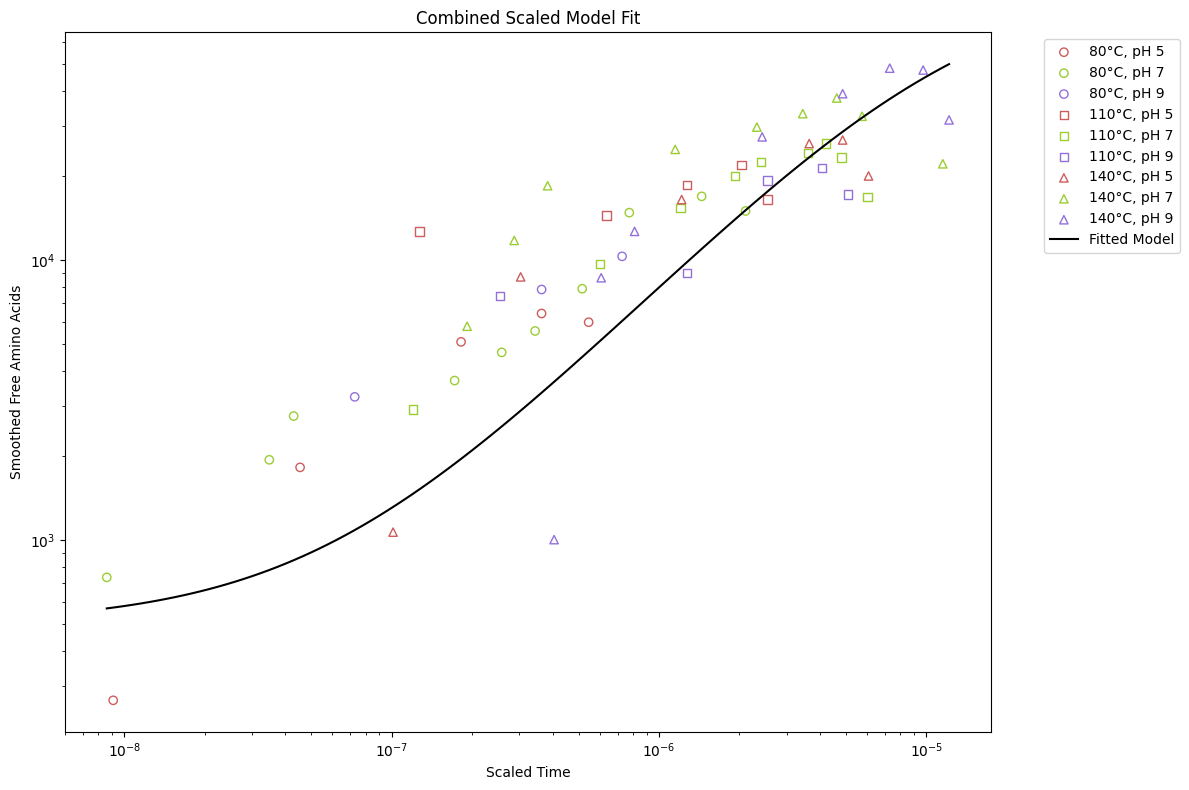

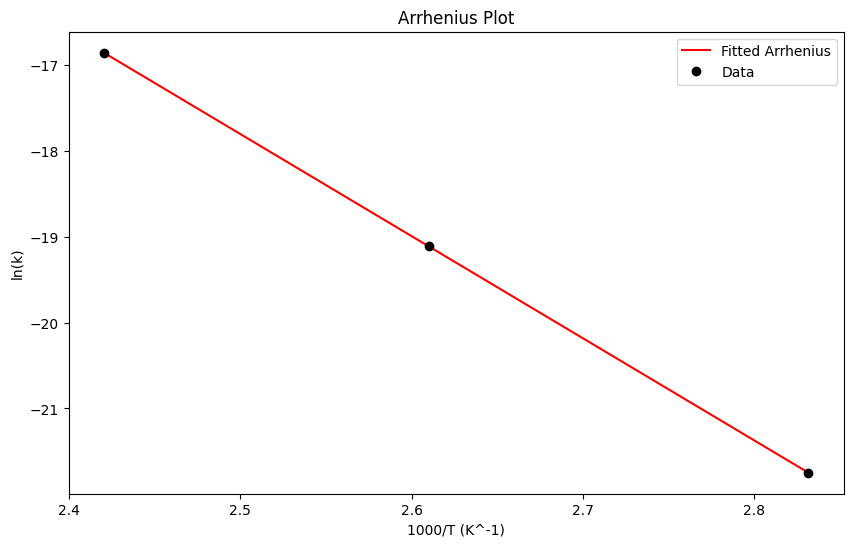

Activation Energy (Ea): 98.97 kJ/mol
Pre-exponential factor (A): 1.56e+05 s^-1
Initial Water Concentration: 80802.84 mol/L
pH 5 factor: 1.06
pH 9 factor: 2.11

Relative rates (compared to 110°C):
80°C: 0.07
110°C: 1.00
140°C: 9.54
Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, curve_fit
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Remove the first time point
data = data[data['time'] > data['time'].min()]

# Constants
R = 8.314  # Gas constant in J/(mol·K)
INITIAL_CONC_AA = 100000  # Initial concentration of total amino acids
INITIAL_CONC_FAA = 500  # Initial concentration of free amino acids

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, INITIAL_CONC_WATER, pH_factor):
    return INITIAL_CONC_FAA + (INITIAL_CONC_WATER * INITIAL_CONC_AA * k * pH_factor * t) / (1 + k * pH_factor * INITIAL_CONC_WATER * t)

# Arrhenius equation
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

# Objective function for optimization
def objective(params, data):
    A, Ea, INITIAL_CONC_WATER, pH_factor_5, pH_factor_9 = params
    residuals = []
    for _, row in data.iterrows():
        k = arrhenius(row['temp_K'], A, Ea)
        pH_factor = 1 if row['pH'] == 7 else (pH_factor_5 if row['pH'] == 5 else pH_factor_9)
        predicted = polymer_degradation_model(row['time'], k, INITIAL_CONC_WATER, pH_factor)
        residuals.append(row['smoothed_FAA'] - predicted)
    return np.array(residuals)

# Fit the model
def fit_model(data):
    # Use the provided fitted values as initial guesses
    initial_guess = [1.56e5, 98960, 80803.18, 1.06, 2.11]
    bounds = [(1e4, 1e6), (50000, 150000), (50000, 150000), (0.1, 10), (0.1, 10)]
    result = differential_evolution(lambda x: np.sum(objective(x, data)**2), bounds, x0=initial_guess,
                                    popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
    return result.x

# Fit the model
fit_results = fit_model(data)
A, Ea, INITIAL_CONC_WATER, pH_factor_5, pH_factor_9 = fit_results

# Calculate rates and pH factors
temperatures = np.array([80, 110, 140])
rates = arrhenius(temperatures + 273.15, A, Ea)
pH_factors = {5: pH_factor_5, 7: 1, 9: pH_factor_9}

# Scale the data
scaled_data = []
for _, row in data.iterrows():
    k = arrhenius(row['temp_K'], A, Ea)
    pH_factor = pH_factors[row['pH']]
    scaled_time = row['time'] * k * pH_factor
    scaled_data.append({
        'scaled_time': scaled_time,
        'smoothed_FAA': row['smoothed_FAA'],
        'temp': row['temp (°C)'],
        'pH': row['pH']
    })
scaled_data = pd.DataFrame(scaled_data)

# Plot combined scaled data
plt.figure(figsize=(12, 8))
temperature_symbols = {80: 'o', 110: 's', 140: '^'}
pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

for temp in temperatures:
    for pH in [5, 7, 9]:
        temp_pH_data = scaled_data[(scaled_data['temp'] == temp) & (scaled_data['pH'] == pH)]
        plt.scatter(temp_pH_data['scaled_time'], temp_pH_data['smoothed_FAA'],
                    label=f'{temp}°C, pH {pH}', marker=temperature_symbols[temp],
                    facecolors='none', edgecolors=pH_colors[pH])

# Fit curve to all scaled data
t_range = np.logspace(np.log10(scaled_data['scaled_time'].min()), np.log10(scaled_data['scaled_time'].max()), 100)
fitted_FAA = polymer_degradation_model(t_range, 1, INITIAL_CONC_WATER, 1)  # k and pH_factor are 1 because data is already scaled
plt.plot(t_range, fitted_FAA, 'k-', label='Fitted Model')

plt.xlabel("Scaled Time")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("Combined Scaled Model Fit")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot Arrhenius relationship
plt.figure(figsize=(10, 6))
T_range = np.linspace(min(temperatures + 273.15), max(temperatures + 273.15), 100)
plt.plot(1000 / T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')
plt.plot(1000 / (temperatures + 273.15), np.log(rates), 'ko', label='Data')
plt.xlabel('1000/T (K^-1)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot')
plt.legend()
plt.show()

# Print results
print(f"Activation Energy (Ea): {Ea / 1000:.2f} kJ/mol")
print(f"Pre-exponential factor (A): {A:.2e} s^-1")
print(f"Initial Water Concentration: {INITIAL_CONC_WATER:.2f} mol/L")
print(f"pH 5 factor: {pH_factor_5:.2f}")
print(f"pH 9 factor: {pH_factor_9:.2f}")
print("\nRelative rates (compared to 110°C):")
for temp in temperatures:
    print(f"{temp}°C: {arrhenius(temp + 273.15, A, Ea) / arrhenius(110 + 273.15, A, Ea):.2f}")

# Save results to CSV
results_data = {
    'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Pre-exponential factor': [A],
    'Initial Water Concentration': [INITIAL_CONC_WATER],
    'pH 5 factor': [pH_factor_5],
    'pH 9 factor': [pH_factor_9],
}

for temp in temperatures:
    results_data[f'Relative rate {temp}°C'] = [arrhenius(temp + 273.15, A, Ea) / arrhenius(110 + 273.15, A, Ea)]

results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

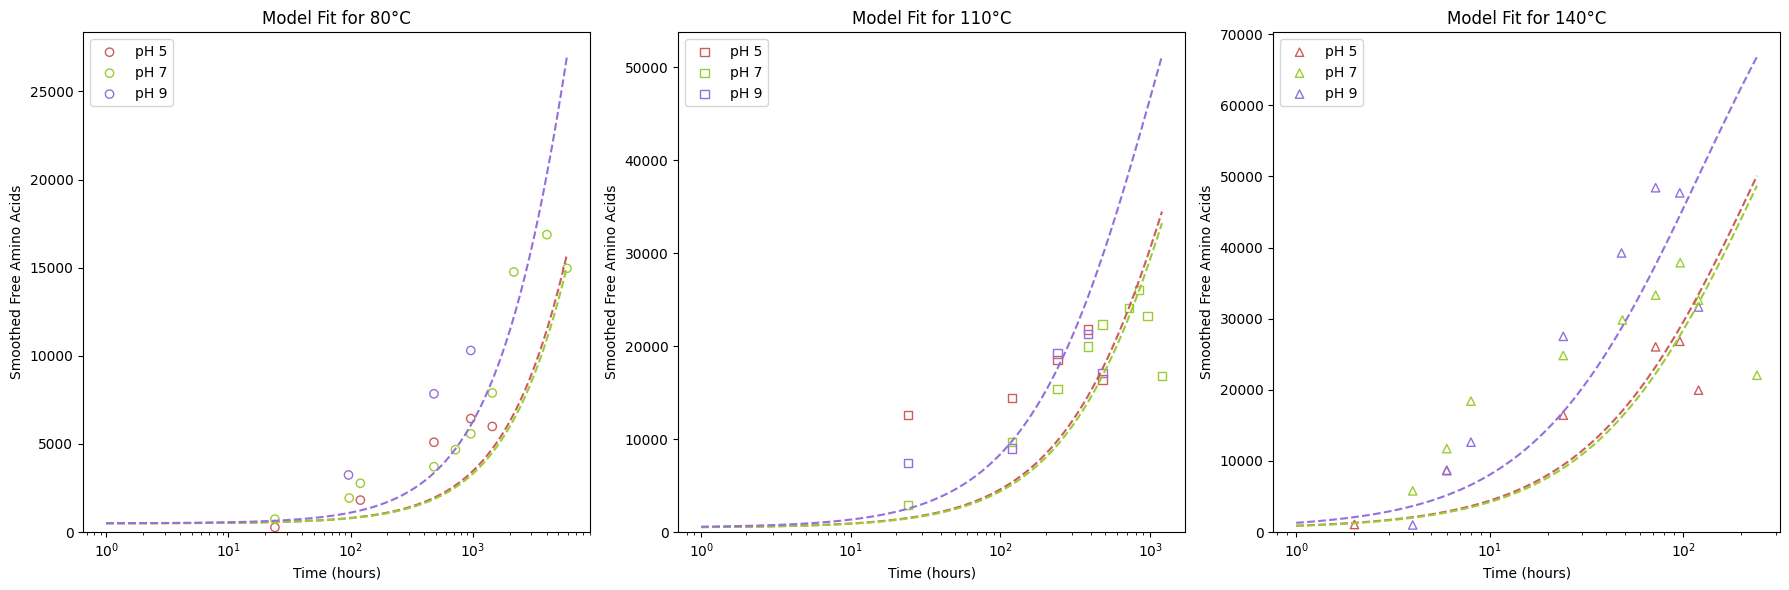

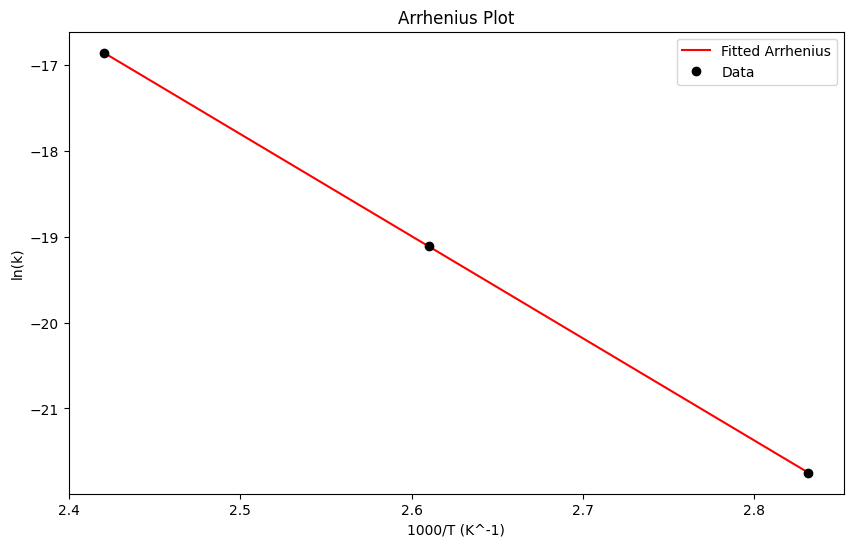

Activation Energy (Ea): 98.96 kJ/mol
Pre-exponential factor (A): 1.56e+05 s^-1
Initial Water Concentration: 80803.18 mol/L
pH 5 factor: 1.06
pH 9 factor: 2.11

Relative rates (compared to 110°C):
80°C: 0.07
110°C: 1.00
140°C: 9.54
Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, curve_fit
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Remove the first time point
data = data[data['time'] > data['time'].min()]

# Constants
R = 8.314  # Gas constant in J/(mol·K)
INITIAL_CONC_AA = 100000  # Initial concentration of total amino acids
INITIAL_CONC_FAA = 500  # Initial concentration of free amino acids

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, INITIAL_CONC_WATER, pH_factor):
    return INITIAL_CONC_FAA + (INITIAL_CONC_WATER * INITIAL_CONC_AA * k * pH_factor * t) / (1 + k * pH_factor * INITIAL_CONC_WATER * t)

# Arrhenius equation
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

# Objective function for optimization
def objective(params, data):
    A, Ea, INITIAL_CONC_WATER, pH_factor_5, pH_factor_9 = params
    residuals = []
    for _, row in data.iterrows():
        k = arrhenius(row['temp_K'], A, Ea)
        pH_factor = 1 if row['pH'] == 7 else (pH_factor_5 if row['pH'] == 5 else pH_factor_9)
        predicted = polymer_degradation_model(row['time'], k, INITIAL_CONC_WATER, pH_factor)
        residuals.append(row['smoothed_FAA'] - predicted)
    return np.array(residuals)

# Fit the model
def fit_model(data):
    bounds = [(1e5, 1e15), (50000, 150000), (50000, 150000), (0.1, 10), (0.1, 10)]
    result = differential_evolution(lambda x: np.sum(objective(x, data)**2), bounds, popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
    return result.x

# Fit the model
fit_results = fit_model(data)
A, Ea, INITIAL_CONC_WATER, pH_factor_5, pH_factor_9 = fit_results

# Calculate rates and pH factors
temperatures = np.array([80, 110, 140])
rates = arrhenius(temperatures + 273.15, A, Ea)
pH_factors = {5: pH_factor_5, 7: 1, 9: pH_factor_9}

# Plot results
plt.figure(figsize=(18, 6))
temperature_symbols = {80: 'o', 110: 's', 140: '^'}
pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

for i, temp in enumerate([80, 110, 140]):
    plt.subplot(1, 3, i + 1)
    temp_data = data[data['temp (°C)'] == temp]

    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['time'], pH_data['smoothed_FAA'],
                    label=f'pH {pH}', marker=temperature_symbols[temp],
                    facecolors='none', edgecolors=pH_colors[pH])

    t_range = np.logspace(0, np.log10(temp_data['time'].max()), 100)
    k = arrhenius(temp + 273.15, A, Ea)
    for pH in [5, 7, 9]:
        fitted_FAA = polymer_degradation_model(t_range, k, INITIAL_CONC_WATER, pH_factors[pH])
        plt.plot(t_range, fitted_FAA, color=pH_colors[pH], linestyle='--')

    plt.xlabel("Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Plot Arrhenius relationship
plt.figure(figsize=(10, 6))
T_range = np.linspace(min(temperatures + 273.15), max(temperatures + 273.15), 100)
plt.plot(1000 / T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')
plt.plot(1000 / (temperatures + 273.15), np.log(rates), 'ko', label='Data')
plt.xlabel('1000/T (K^-1)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot')
plt.legend()
plt.show()

# Print results
print(f"Activation Energy (Ea): {Ea / 1000:.2f} kJ/mol")
print(f"Pre-exponential factor (A): {A:.2e} s^-1")
print(f"Initial Water Concentration: {INITIAL_CONC_WATER:.2f} mol/L")
print(f"pH 5 factor: {pH_factor_5:.2f}")
print(f"pH 9 factor: {pH_factor_9:.2f}")
print("\nRelative rates (compared to 110°C):")
for temp in temperatures:
    print(f"{temp}°C: {arrhenius(temp + 273.15, A, Ea) / arrhenius(110 + 273.15, A, Ea):.2f}")

# Save results to CSV
results_data = {
    'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Pre-exponential factor': [A],
    'Initial Water Concentration': [INITIAL_CONC_WATER],
    'pH 5 factor': [pH_factor_5],
    'pH 9 factor': [pH_factor_9],
}

for temp in temperatures:
    results_data[f'Relative rate {temp}°C'] = [arrhenius(temp + 273.15, A, Ea) / arrhenius(110 + 273.15, A, Ea)]

results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


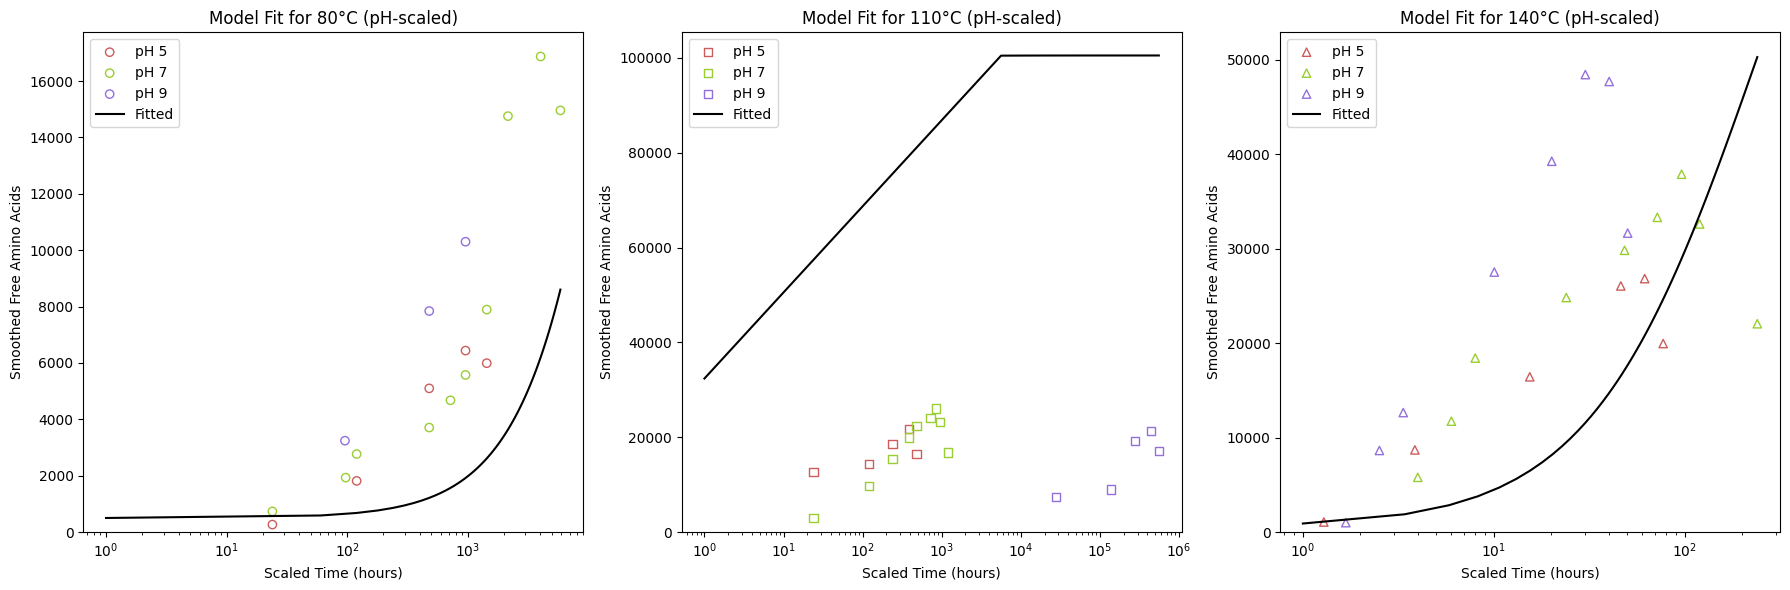

<ipython-input-22-1babd4d972df>:149: RuntimeWarning: invalid value encountered in log
  plt.plot(1000 / T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')


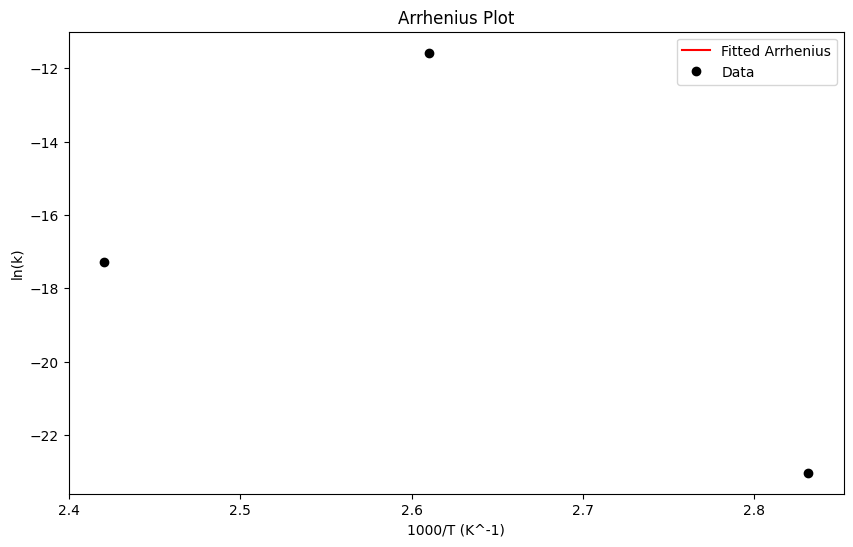

Activation Energy (Ea): 247.91 kJ/mol
Pre-exponential factor (A): -3.13e+11 s^-1
Initial Free Amino Acid Concentration: 500.00 mol/L
Initial Total Amino Acid Concentration: 100000.00 mol/L

Relative rates (compared to 110°C):
80°C: 0.00
110°C: 1.00
140°C: 284.58
Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, curve_fit
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Remove the first time point
data = data[data['time'] > data['time'].min()]

# Constants
R = 8.314  # Gas constant in J/(mol·K)
INITIAL_CONC_AA = 100000  # Initial concentration of total amino acids
INITIAL_CONC_FAA = 500  # Initial concentration of free amino acids

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, INITIAL_CONC_WATER):
    return INITIAL_CONC_FAA + (INITIAL_CONC_WATER * INITIAL_CONC_AA * k * t) / (1 + k * INITIAL_CONC_WATER * t)

# Objective function for optimization
def objective(params, t, y):
    k, INITIAL_CONC_WATER = params
    y_pred = polymer_degradation_model(t, k, INITIAL_CONC_WATER)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature and pH
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        for pH in [5, 7, 9]:
            pH_data = temp_data[temp_data['pH'] == pH]
            t = pH_data['time'].values
            y = pH_data['smoothed_FAA'].values

            bounds = [(1e-10, 1e-3), (50000, 150000)]  # (k, INITIAL_CONC_WATER)
            result = differential_evolution(objective, bounds, args=(t, y), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
            results[(temp, pH)] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Scale rates to pH 7
pH_7_rates = {temp: fit_results[(temp, 7)][0] for temp in [80, 110, 140]}
pH_scaling_factors = {
    temp: {
        pH: fit_results[(temp, pH)][0] / pH_7_rates[temp]
        for pH in [5, 7, 9]
    }
    for temp in [80, 110, 140]
}

# Scale data to pH 7
scaled_data = []
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        scaled_time = pH_data['time'] / pH_scaling_factors[temp][pH]
        scaled_data.append(pd.DataFrame({
            'scaled_time': scaled_time,
            'smoothed_FAA': pH_data['smoothed_FAA'],
            'temp': temp,
            'pH': pH,
            'temp_K': temp + 273.15
        }))

scaled_data = pd.concat(scaled_data)

# Fit Arrhenius relationship
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

temperatures = np.array([80, 110, 140]) + 273.15
rates = np.array([pH_7_rates[temp] for temp in [80, 110, 140]])

# Increase maxfev to allow more iterations
popt, _ = curve_fit(arrhenius, temperatures, rates, p0=[1e10, 98000], maxfev=10000)
A, Ea = popt

# Calculate relative rate differences
rate_110 = arrhenius(383.15, A, Ea)
relative_rates = {temp: arrhenius(temp + 273.15, A, Ea) / rate_110 for temp in [80, 110, 140]}

# Fit the water concentration to best fit the shapes of the curve
def fit_water_concentration(scaled_data, fit_results):
    water_results = {}
    for temp in [80, 110, 140]:
        temp_data = scaled_data[scaled_data['temp'] == temp]
        for pH in [5, 7, 9]:
            pH_data = temp_data[temp_data['pH'] == pH]
            t = pH_data['scaled_time'].values  # Get time values
            y = pH_data['smoothed_FAA'].values

            k = fit_results[(temp, 7)][0]  # Use the k value fitted to pH 7
            # Include bounds for k as well, even though it's fixed
            bounds = [(k, k), (50000, 150000)]  # (k, INITIAL_CONC_WATER)
            # Pass (t, y) as arguments to objective
            result = differential_evolution(objective, bounds, args=(t, y), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
            water_results[(temp, pH)] = result.x[1] # Extract INITIAL_CONC_WATER

    return water_results

water_results = fit_water_concentration(scaled_data, fit_results)

# Plot results
plt.figure(figsize=(18, 6))
temperature_symbols = {80: 'o', 110: 's', 140: '^'}
pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

for i, temp in enumerate([80, 110, 140]):
    plt.subplot(1, 3, i + 1)
    temp_data = scaled_data[scaled_data['temp'] == temp]

    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['scaled_time'], pH_data['smoothed_FAA'],
                    label=f'pH {pH}', marker=temperature_symbols[temp],
                    facecolors='none', edgecolors=pH_colors[pH])

    t_range = np.linspace(1, temp_data['scaled_time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, pH_7_rates[temp], water_results[(temp, 7)])
    plt.plot(t_range, fitted_FAA, label='Fitted', color='black')

    plt.xlabel("Scaled Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C (pH-scaled)")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Plot Arrhenius relationship
plt.figure(figsize=(10, 6))
T_range = np.linspace(min(temperatures), max(temperatures), 100)
plt.plot(1000 / T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')
plt.plot(1000 / temperatures, np.log(rates), 'ko', label='Data')
plt.xlabel('1000/T (K^-1)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot')
plt.legend()
plt.show()

# Print results
print(f"Activation Energy (Ea): {Ea / 1000:.2f} kJ/mol")
print(f"Pre-exponential factor (A): {A:.2e} s^-1")
print(f"Initial Free Amino Acid Concentration: {INITIAL_CONC_FAA:.2f} mol/L")
print(f"Initial Total Amino Acid Concentration: {INITIAL_CONC_AA:.2f} mol/L")
print("\nRelative rates (compared to 110°C):")
for temp in [80, 110, 140]:
    print(f"{temp}°C: {relative_rates[temp]:.2f}")

# Save results to CSV
results_data = {
    'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Pre-exponential factor': [A],
    'Initial Free Amino Acid Concentration': [INITIAL_CONC_FAA],
    'Initial Total Amino Acid Concentration': [INITIAL_CONC_AA],
    'Relative rate 80°C': [relative_rates[80]],
    'Relative rate 110°C': [relative_rates[110]],
    'Relative rate 140°C': [relative_rates[140]]
}

for temp in [80, 110, 140]:
    for pH in [5, 7, 9]:
        results_data.update({
            f'k ({temp}°C, pH {pH})': [fit_results[(temp, pH)][0]],
            f'pH scaling factor ({temp}°C, pH {pH})': [pH_scaling_factors[temp][pH]],
            f'Water concentration ({temp}°C, pH {pH})': [water_results[(temp, pH)]]
        })

results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")


In [ ]:
def fit_water_concentration(scaled_data, fit_results):
    water_results = {}
    for temp in [80, 110, 140]:
        temp_data = scaled_data[scaled_data['temp'] == temp]
        for pH in [5, 7, 9]:
            pH_data = temp_data[temp_data['pH'] == pH]
            t = pH_data['scaled_time'].values  # Get time values
            y = pH_data['smoothed_FAA'].values

            k = fit_results[(temp, 7)][0]  # Use the k value fitted to pH 7
            bounds = [(50000, 150000)]  # INITIAL_CONC_WATER
            # Pass (t, y) as arguments to objective
            result = differential_evolution(objective, bounds, args=(t, y), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
            water_results[(temp, pH)] = result.x[0]

    return water_results

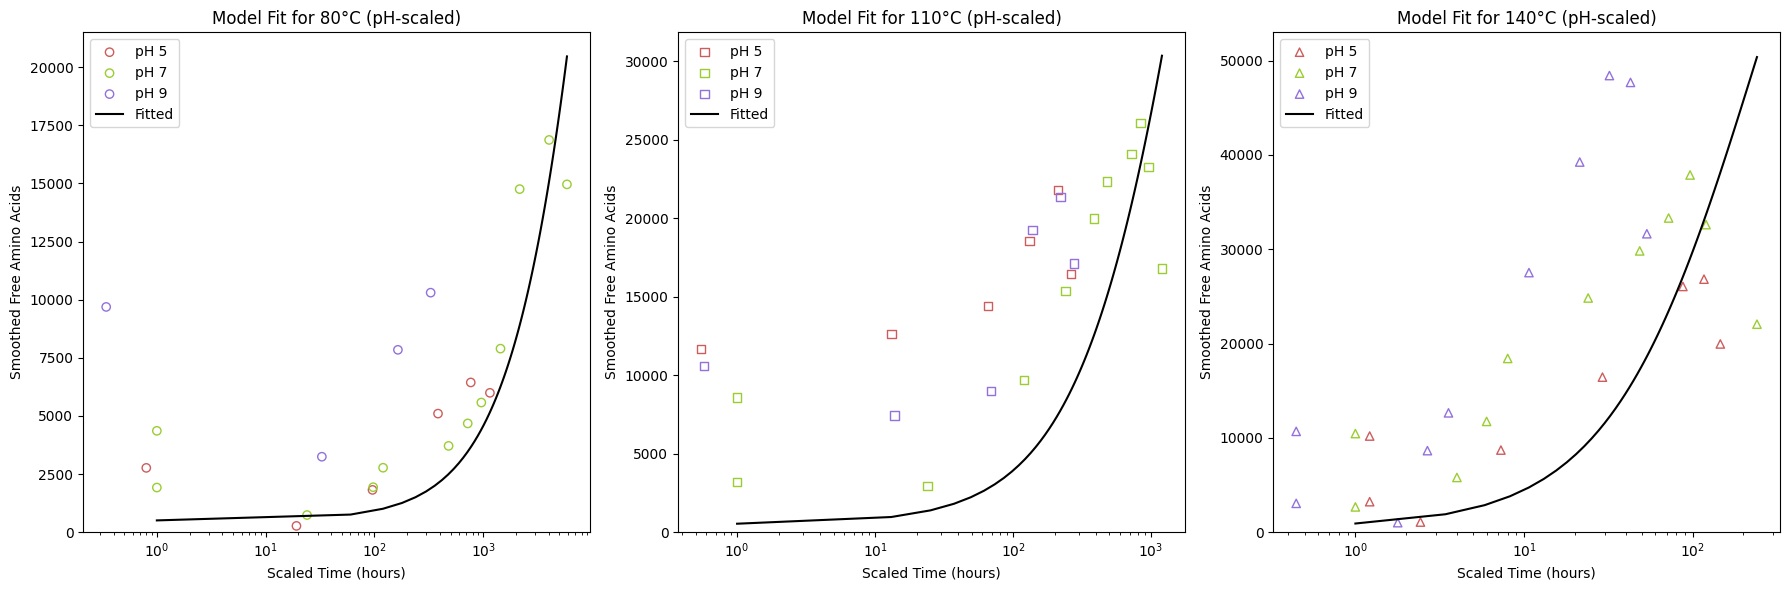

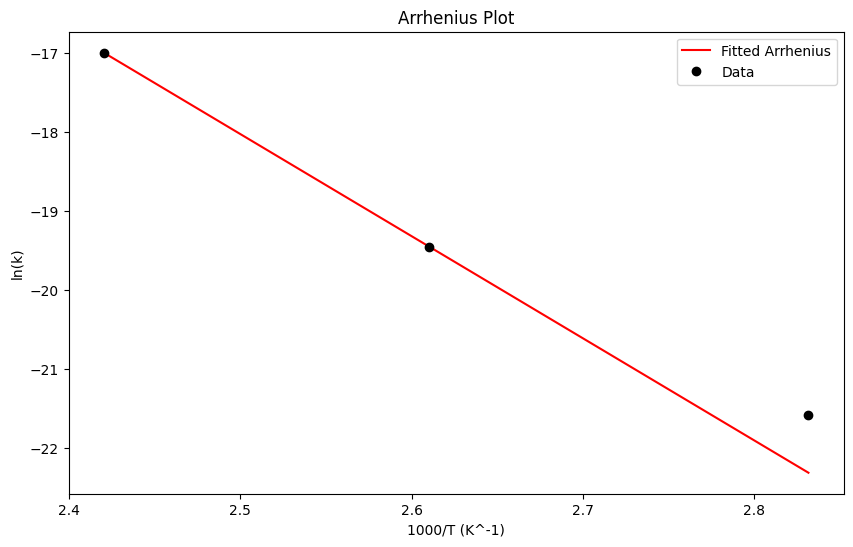

Activation Energy (Ea): 107.46 kJ/mol
Pre-exponential factor (A): 1.60e+06 s^-1
Initial Water Concentration: 100000.00 mol/L
Initial Free Amino Acid Concentration: 500.00 mol/L
Initial Total Amino Acid Concentration: 100000.00 mol/L

Relative rates (compared to 110°C):
80°C: 0.06
110°C: 1.00
140°C: 11.58
Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, curve_fit
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
INITIAL_CONC_WATER = 100000  # Initial concentration of water
INITIAL_CONC_AA = 100000  # Initial concentration of total amino acids
INITIAL_CONC_FAA = 500  # Initial concentration of free amino acids

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k):
    return INITIAL_CONC_FAA + (INITIAL_CONC_WATER * INITIAL_CONC_AA * k * t) / (1 + k * INITIAL_CONC_WATER * t)

# Objective function for optimization
def objective(params, t, y):
    k = params[0]
    y_pred = polymer_degradation_model(t, k)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature and pH
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        for pH in [5, 7, 9]:
            pH_data = temp_data[temp_data['pH'] == pH]
            t = pH_data['time'].values
            y = pH_data['smoothed_FAA'].values

            bounds = [(1e-10, 1e-3)]  # (k)
            result = differential_evolution(objective, bounds, args=(t, y), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
            results[(temp, pH)] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Scale rates to pH 7
pH_7_rates = {temp: fit_results[(temp, 7)][0] for temp in [80, 110, 140]}
pH_scaling_factors = {
    temp: {
        pH: fit_results[(temp, pH)][0] / pH_7_rates[temp]
        for pH in [5, 7, 9]
    }
    for temp in [80, 110, 140]
}

# Scale data to pH 7
scaled_data = []
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        scaled_time = pH_data['time'] / pH_scaling_factors[temp][pH]
        scaled_data.append(pd.DataFrame({
            'scaled_time': scaled_time,
            'smoothed_FAA': pH_data['smoothed_FAA'],
            'temp': temp,
            'pH': pH,
            'temp_K': temp + 273.15
        }))

scaled_data = pd.concat(scaled_data)

# Fit Arrhenius relationship
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

temperatures = np.array([80, 110, 140]) + 273.15
rates = np.array([pH_7_rates[temp] for temp in [80, 110, 140]])

# Increase maxfev to allow more iterations
popt, _ = curve_fit(arrhenius, temperatures, rates, p0=[1e10, 98000], maxfev=10000)
A, Ea = popt

# Calculate relative rate differences
rate_110 = arrhenius(383.15, A, Ea)
relative_rates = {temp: arrhenius(temp + 273.15, A, Ea) / rate_110 for temp in [80, 110, 140]}

# Plot results
plt.figure(figsize=(18, 6))
temperature_symbols = {80: 'o', 110: 's', 140: '^'}
pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

for i, temp in enumerate([80, 110, 140]):
    plt.subplot(1, 3, i + 1)
    temp_data = scaled_data[scaled_data['temp'] == temp]

    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['scaled_time'], pH_data['smoothed_FAA'],
                    label=f'pH {pH}', marker=temperature_symbols[temp],
                    facecolors='none', edgecolors=pH_colors[pH])

    t_range = np.linspace(1, temp_data['scaled_time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, pH_7_rates[temp])
    plt.plot(t_range, fitted_FAA, label='Fitted', color='black')

    plt.xlabel("Scaled Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C (pH-scaled)")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Plot Arrhenius relationship
plt.figure(figsize=(10, 6))
T_range = np.linspace(min(temperatures), max(temperatures), 100)
plt.plot(1000 / T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')
plt.plot(1000 / temperatures, np.log(rates), 'ko', label='Data')
plt.xlabel('1000/T (K^-1)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot')
plt.legend()
plt.show()

# Print results
print(f"Activation Energy (Ea): {Ea / 1000:.2f} kJ/mol")
print(f"Pre-exponential factor (A): {A:.2e} s^-1")
print(f"Initial Water Concentration: {INITIAL_CONC_WATER:.2f} mol/L")
print(f"Initial Free Amino Acid Concentration: {INITIAL_CONC_FAA:.2f} mol/L")
print(f"Initial Total Amino Acid Concentration: {INITIAL_CONC_AA:.2f} mol/L")
print("\nRelative rates (compared to 110°C):")
for temp in [80, 110, 140]:
    print(f"{temp}°C: {relative_rates[temp]:.2f}")

# Save results to CSV
results_data = {
    'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Pre-exponential factor': [A],
    'Initial Water Concentration': [INITIAL_CONC_WATER],
    'Initial Free Amino Acid Concentration': [INITIAL_CONC_FAA],
    'Initial Total Amino Acid Concentration': [INITIAL_CONC_AA],
    'Relative rate 80°C': [relative_rates[80]],
    'Relative rate 110°C': [relative_rates[110]],
    'Relative rate 140°C': [relative_rates[140]]
}

for temp in [80, 110, 140]:
    for pH in [5, 7, 9]:
        results_data.update({
            f'k ({temp}°C, pH {pH})': [fit_results[(temp, pH)][0]],
            f'pH scaling factor ({temp}°C, pH {pH})': [pH_scaling_factors[temp][pH]]
        })

results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")


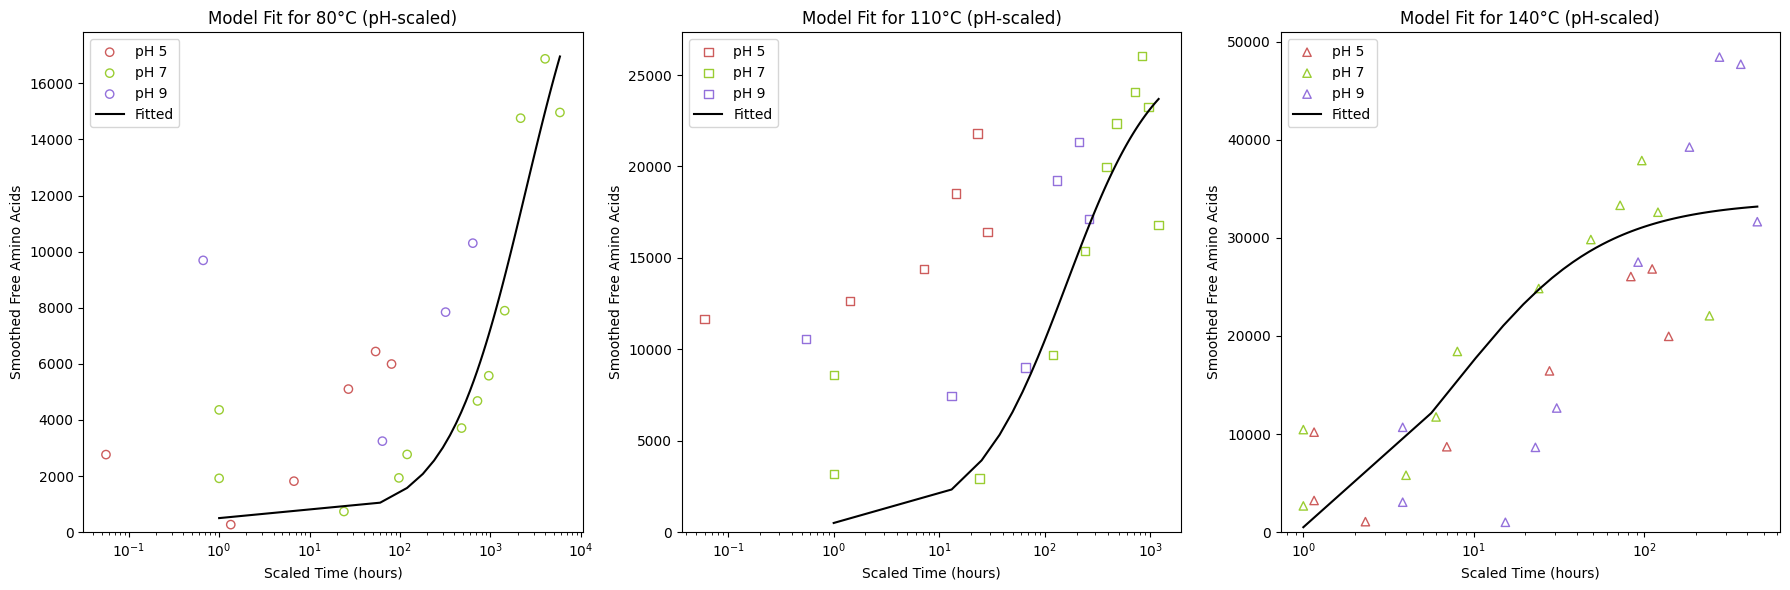

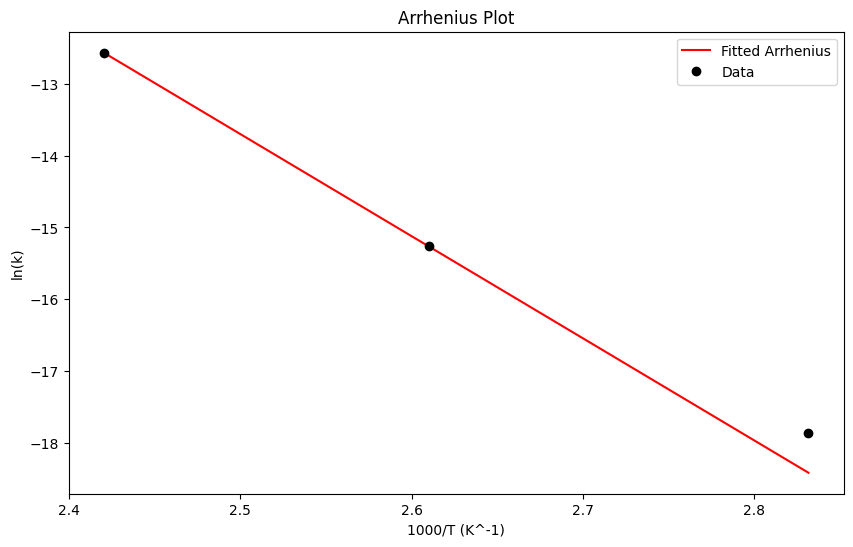

Activation Energy (Ea): 118.30 kJ/mol
Pre-exponential factor (A): 3.16e+09 s^-1
Concentration A: 500.00 mol/L
Concentration B: 100000.00 mol/L

Relative rates (compared to 110°C):
80°C: 0.04
110°C: 1.00
140°C: 14.83
Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, curve_fit
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
INITIAL_CONC = 500  # Initial concentration
B_CONC = 100000  # Concentration B as specified

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y):
    k, A = params
    y_pred = polymer_degradation_model(t, k, A)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature and pH
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        for pH in [5, 7, 9]:
            pH_data = temp_data[temp_data['pH'] == pH]
            t = pH_data['time'].values
            y = pH_data['smoothed_FAA'].values

            bounds = [(1e-10, 1e-3), (INITIAL_CONC, B_CONC)]  # (k, A)
            result = differential_evolution(objective, bounds, args=(t, y), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
            results[(temp, pH)] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Scale rates to pH 7
pH_7_rates = {temp: fit_results[(temp, 7)][0] for temp in [80, 110, 140]}
pH_scaling_factors = {
    temp: {
        pH: fit_results[(temp, pH)][0] / pH_7_rates[temp]
        for pH in [5, 7, 9]
    }
    for temp in [80, 110, 140]
}

# Scale data to pH 7
scaled_data = []
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        scaled_time = pH_data['time'] / pH_scaling_factors[temp][pH]
        scaled_data.append(pd.DataFrame({
            'scaled_time': scaled_time,
            'smoothed_FAA': pH_data['smoothed_FAA'],
            'temp': temp,
            'pH': pH,
            'temp_K': temp + 273.15
        }))

scaled_data = pd.concat(scaled_data)

# Fit Arrhenius relationship
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

temperatures = np.array([80, 110, 140]) + 273.15
rates = np.array([pH_7_rates[temp] for temp in [80, 110, 140]])

popt, _ = curve_fit(arrhenius, temperatures, rates, p0=[1e10, 98000])
A, Ea = popt

# Calculate relative rate differences
rate_110 = arrhenius(383.15, A, Ea)
relative_rates = {temp: arrhenius(temp+273.15, A, Ea) / rate_110 for temp in [80, 110, 140]}

# Plot results
plt.figure(figsize=(18, 6))
temperature_symbols = {80: 'o', 110: 's', 140: '^'}
pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

for i, temp in enumerate([80, 110, 140]):
    plt.subplot(1, 3, i+1)
    temp_data = scaled_data[scaled_data['temp'] == temp]

    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['scaled_time'], pH_data['smoothed_FAA'],
                    label=f'pH {pH}', marker=temperature_symbols[temp],
                    facecolors='none', edgecolors=pH_colors[pH])

    t_range = np.linspace(1, temp_data['scaled_time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, pH_7_rates[temp], fit_results[(temp, 7)][1])
    plt.plot(t_range, fitted_FAA, label='Fitted', color='black')

    plt.xlabel("Scaled Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C (pH-scaled)")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Plot Arrhenius relationship
plt.figure(figsize=(10, 6))
T_range = np.linspace(min(temperatures), max(temperatures), 100)
plt.plot(1000/T_range, np.log(arrhenius(T_range, A, Ea)), 'r-', label='Fitted Arrhenius')
plt.plot(1000/temperatures, np.log(rates), 'ko', label='Data')
plt.xlabel('1000/T (K^-1)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot')
plt.legend()
plt.show()

# Print results
print(f"Activation Energy (Ea): {Ea/1000:.2f} kJ/mol")
print(f"Pre-exponential factor (A): {A:.2e} s^-1")
print(f"Concentration A: {INITIAL_CONC:.2f} mol/L")
print(f"Concentration B: {B_CONC:.2f} mol/L")
print("\nRelative rates (compared to 110°C):")
for temp in [80, 110, 140]:
    print(f"{temp}°C: {relative_rates[temp]:.2f}")

# Save results to CSV
results_data = {
    'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Pre-exponential factor': [A],
    'Initial Concentration': [INITIAL_CONC],
    'Concentration B': [B_CONC],
    'Relative rate 80°C': [relative_rates[80]],
    'Relative rate 110°C': [relative_rates[110]],
    'Relative rate 140°C': [relative_rates[140]]
}

for temp in [80, 110, 140]:
    for pH in [5, 7, 9]:
        results_data.update({
            f'k ({temp}°C, pH {pH})': [fit_results[(temp, pH)][0]],
            f'A ({temp}°C, pH {pH})': [fit_results[(temp, pH)][1]],
            f'pH scaling factor ({temp}°C, pH {pH})': [pH_scaling_factors[temp][pH]]
        })

results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

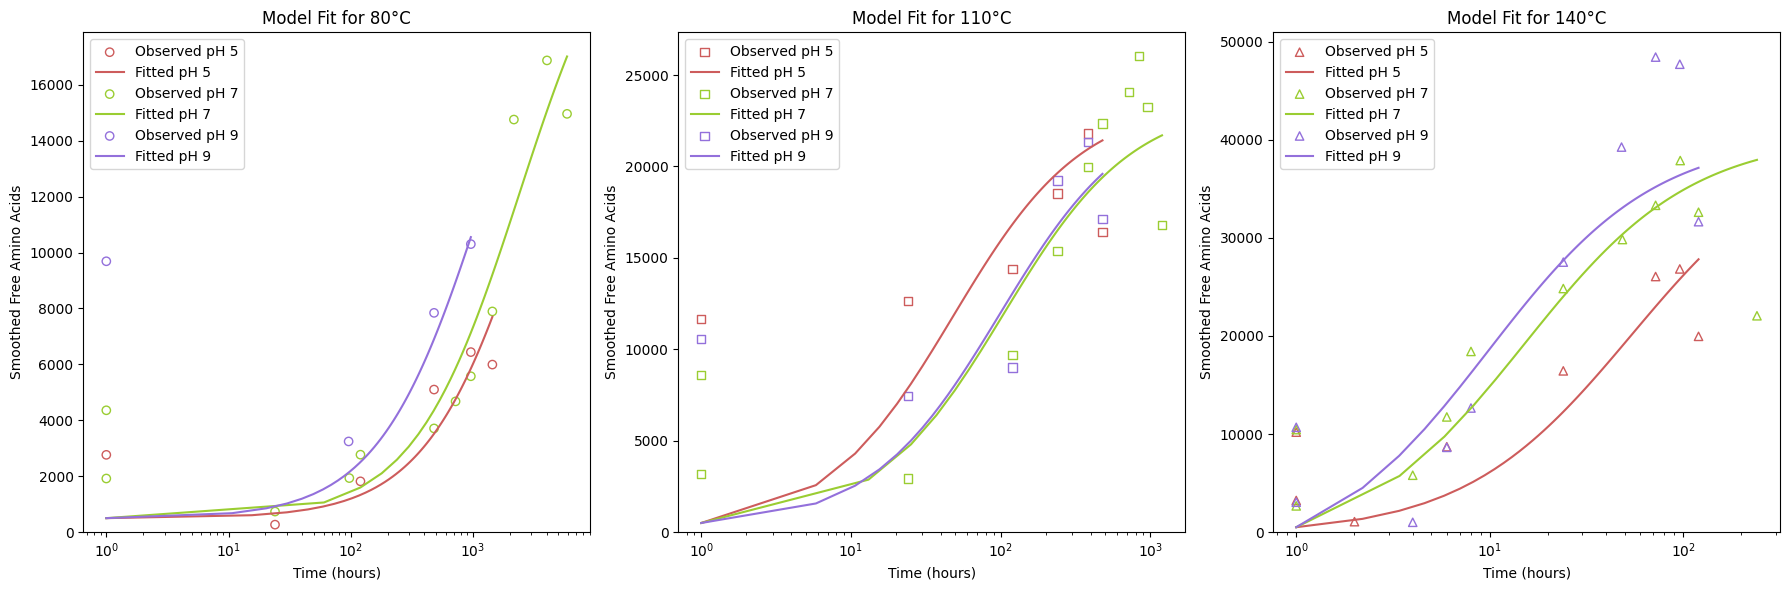

Rate difference (140°C / 80°C): 87.14

Fitted parameters for 80°C:
k = 1.786577e-08
A = 23771.54
pH 5 factor = 0.75
pH 9 factor = 1.91

Fitted parameters for 110°C:
k = 4.099070e-07
A = 23570.23
pH 5 factor = 2.15
pH 9 factor = 1.06

Fitted parameters for 140°C:
k = 1.556877e-06
A = 40455.06
pH 5 factor = 0.29
pH 9 factor = 1.49


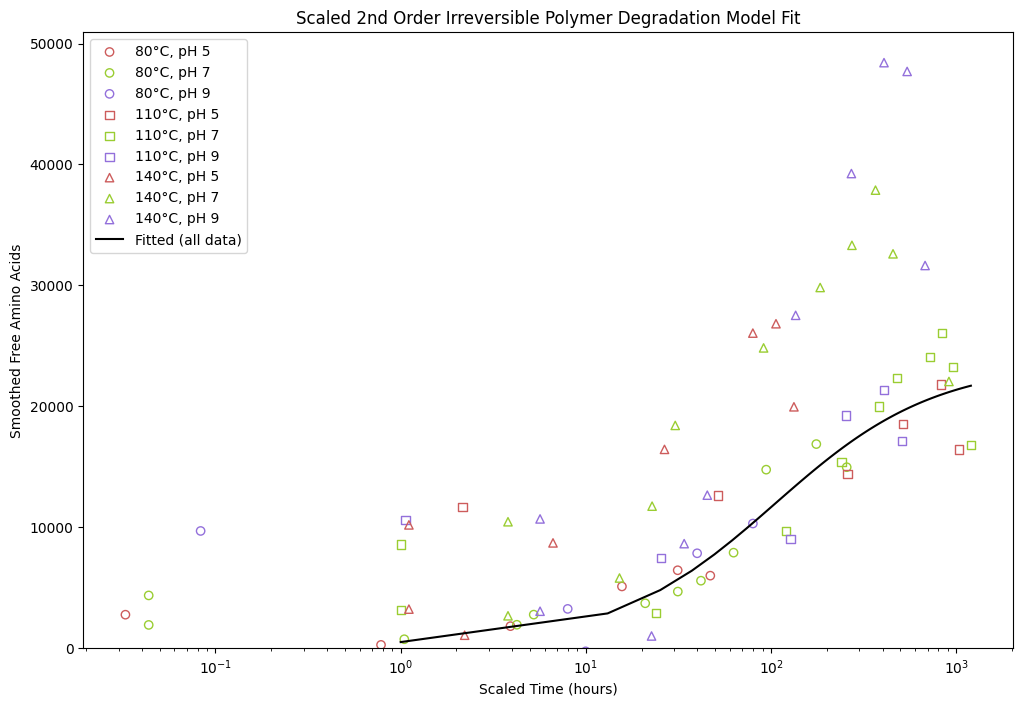

Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
INITIAL_CONC = 500  # Force initial concentration to 3000

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A, pH_factor=1):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * pH_factor * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y, T, pH):
    k, A, pH_5_factor, pH_9_factor = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    pH_factor = np.where(pH == 5, pH_5_factor, np.where(pH == 9, pH_9_factor, 1))
    y_pred = polymer_degradation_model(t, k_T, A, pH_factor)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]
        pH = temp_data['pH'].values

        bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5), (0.1, 10), (0.1, 10)]  # (k, A, pH_5_factor, pH_9_factor)
        result = differential_evolution(objective, bounds, args=(t, y, T, pH), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)


# Define temperature symbols for plotting (add this section)
temperature_symbols = {
    80: 'o',
    110: 's',
    140: '^'
}

# Define pH colors for plotting (add this section)

pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

# Calculate rate constants and plot results
plt.figure(figsize=(18, 6))
rate_constants = {}
pH_factors = {}

for i, temp in enumerate([80, 110, 140]):
    k, A, pH_5_factor, pH_9_factor = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T
    pH_factors[temp] = {'pH_5': pH_5_factor, 'pH_7': 1, 'pH_9': pH_9_factor}

    temp_data = data[data['temp (°C)'] == temp]

    plt.subplot(1, 3, i+1)
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['time'], pH_data['smoothed_FAA'], label=f'Observed pH {pH}', marker=temperature_symbols[temp], facecolors='none', edgecolors=pH_colors[pH])

        t_range = np.linspace(1, pH_data['time'].max(), 100)
        pH_factor = pH_factors[temp][f'pH_{pH}']
        fitted_FAA = polymer_degradation_model(t_range, k_T, A, pH_factor)
        plt.plot(t_range, fitted_FAA, label=f'Fitted pH {pH}', color=pH_colors[pH])

    plt.xlabel("Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")
for temp in [80, 110, 140]:
    print(f"\nFitted parameters for {temp}°C:")
    print(f"k = {rate_constants[temp]:.6e}")
    print(f"A = {fit_results[temp][1]:.2f}")
    print(f"pH 5 factor = {pH_factors[temp]['pH_5']:.2f}")
    print(f"pH 9 factor = {pH_factors[temp]['pH_9']:.2f}")

# Plot with scaled rates
plt.figure(figsize=(12, 8))
scaled_data = []

for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    scale_factor = rate_constants[temp] / rate_constants[110]  # Scale to 110°C
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        scaled_time = pH_data['time'] * scale_factor * pH_factors[temp][f'pH_{pH}']
        plt.scatter(scaled_time, pH_data['smoothed_FAA'], label=f'{temp}°C, pH {pH}', marker=temperature_symbols[temp], facecolors='none', edgecolors=pH_colors[pH])

        scaled_data.append(pd.DataFrame({
            'scaled_time': scaled_time,
            'smoothed_FAA': pH_data['smoothed_FAA'],
            'temp': temp,
            'pH': pH
        }))

# Fit curve to all scaled data
all_scaled_data = pd.concat(scaled_data)
k_110, A_110, _, _ = fit_results[110]
t_range = np.linspace(1, all_scaled_data['scaled_time'].max(), 100)
fitted_FAA = polymer_degradation_model(t_range, k_110, A_110)
plt.plot(t_range, fitted_FAA, label='Fitted (all data)', color='black')

plt.xlabel("Scaled Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("Scaled 2nd Order Irreversible Polymer Degradation Model Fit")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare data for CSV
current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_data = {
    'Date': [current_date],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Initial Concentration': [INITIAL_CONC],
    'Rate difference (140°C / 80°C)': [rate_constants[140] / rate_constants[80]]
}

for temp in [80, 110, 140]:
    results_data.update({
        f'k ({temp}°C)': [rate_constants[temp]],
        f'A ({temp}°C)': [fit_results[temp][1]],
        f'pH 5 factor ({temp}°C)': [pH_factors[temp]['pH_5']],
        f'pH 9 factor ({temp}°C)': [pH_factors[temp]['pH_9']]
    })

# Create DataFrame and save to CSV
results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

# If the file doesn't exist, create it with headers. If it exists, append without headers.
if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

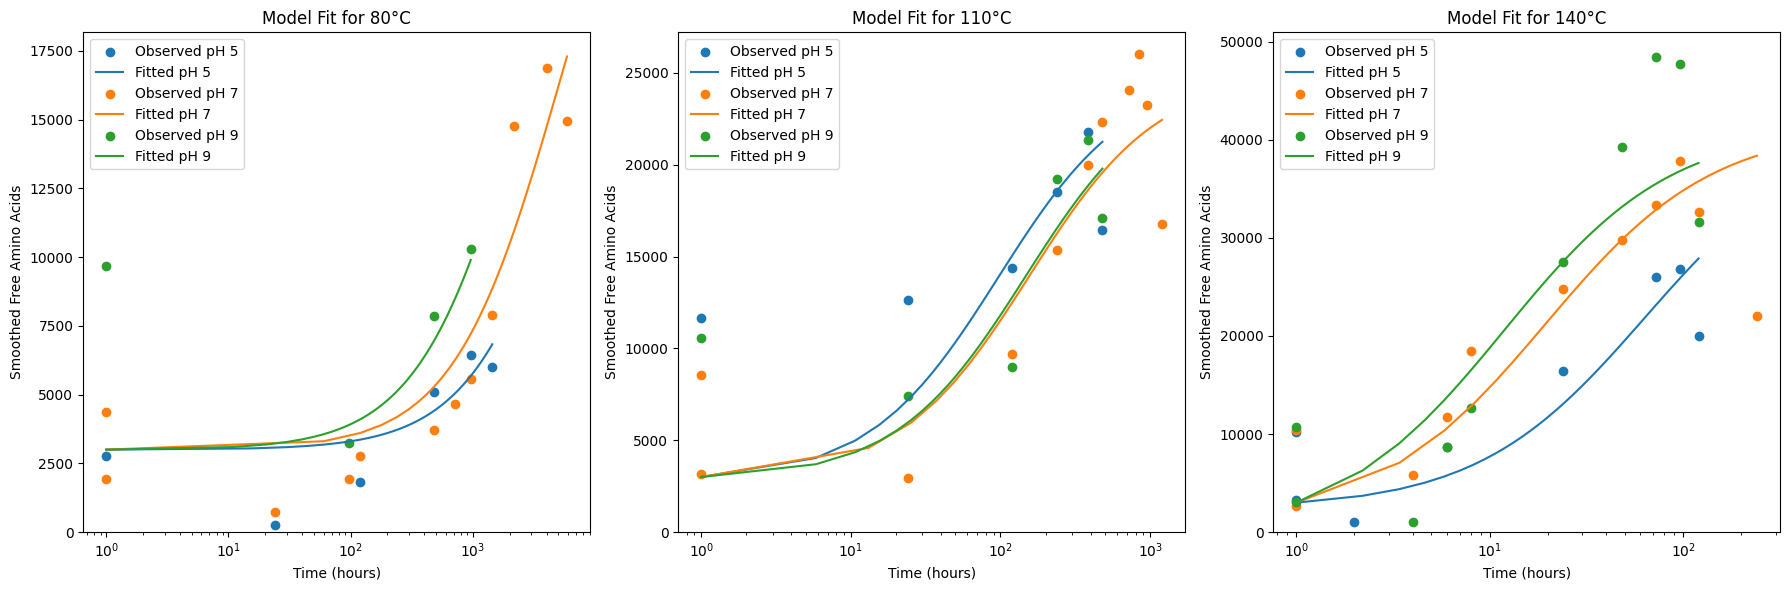

Rate difference (140°C / 80°C): 176.38

Fitted parameters for 80°C:
k = 7.248773e-09
A = 29812.07
pH 5 factor = 0.60
pH 9 factor = 1.86

Fitted parameters for 110°C:
k = 2.916701e-07
A = 24974.55
pH 5 factor = 1.60
pH 9 factor = 1.06

Fitted parameters for 140°C:
k = 1.278558e-06
A = 41375.91
pH 5 factor = 0.32
pH 9 factor = 1.58


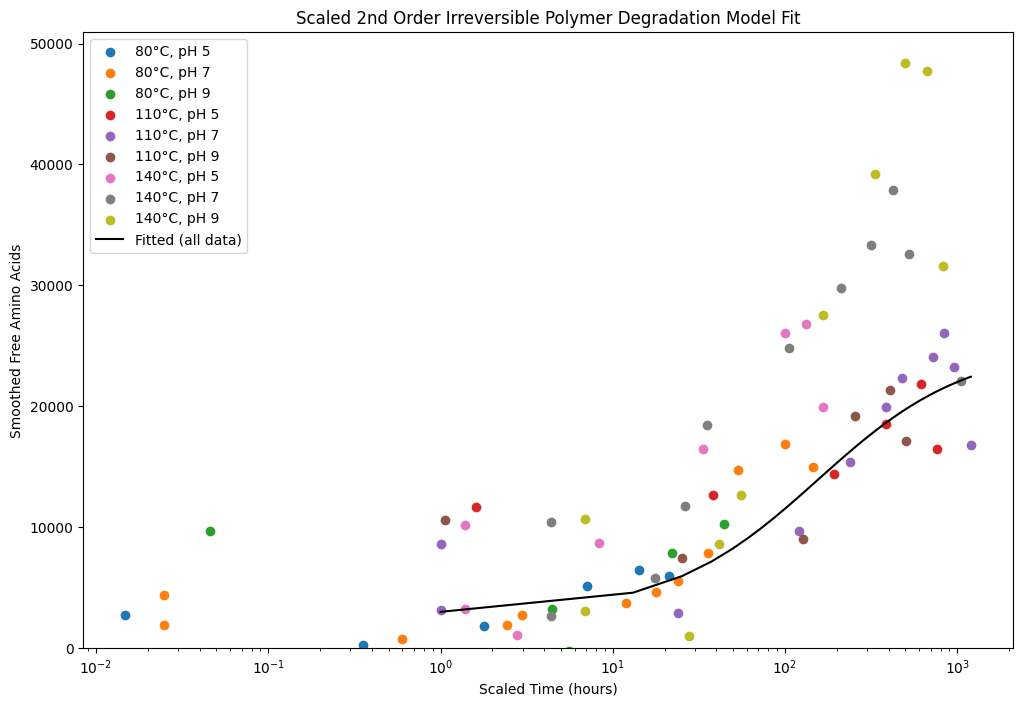

Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
INITIAL_CONC = 3000  # Force initial concentration to 3000

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A, pH_factor=1):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * pH_factor * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y, T, pH):
    k, A, pH_5_factor, pH_9_factor = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    pH_factor = np.where(pH == 5, pH_5_factor, np.where(pH == 9, pH_9_factor, 1))
    y_pred = polymer_degradation_model(t, k_T, A, pH_factor)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]
        pH = temp_data['pH'].values

        bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5), (0.1, 10), (0.1, 10)]  # (k, A, pH_5_factor, pH_9_factor)
        result = differential_evolution(objective, bounds, args=(t, y, T, pH), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Calculate rate constants and plot results
plt.figure(figsize=(18, 6))
rate_constants = {}
pH_factors = {}

for i, temp in enumerate([80, 110, 140]):
    k, A, pH_5_factor, pH_9_factor = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T
    pH_factors[temp] = {'pH_5': pH_5_factor, 'pH_7': 1, 'pH_9': pH_9_factor}

    temp_data = data[data['temp (°C)'] == temp]

    plt.subplot(1, 3, i+1)
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        plt.scatter(pH_data['time'], pH_data['smoothed_FAA'], label=f'Observed pH {pH}')

        t_range = np.linspace(1, pH_data['time'].max(), 100)
        pH_factor = pH_factors[temp][f'pH_{pH}']
        fitted_FAA = polymer_degradation_model(t_range, k_T, A, pH_factor)
        plt.plot(t_range, fitted_FAA, label=f'Fitted pH {pH}')

    plt.xlabel("Time (hours)")
    plt.ylabel("Smoothed Free Amino Acids")
    plt.title(f"Model Fit for {temp}°C")
    plt.legend()
    plt.xscale('log')
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")
for temp in [80, 110, 140]:
    print(f"\nFitted parameters for {temp}°C:")
    print(f"k = {rate_constants[temp]:.6e}")
    print(f"A = {fit_results[temp][1]:.2f}")
    print(f"pH 5 factor = {pH_factors[temp]['pH_5']:.2f}")
    print(f"pH 9 factor = {pH_factors[temp]['pH_9']:.2f}")

# Plot with scaled rates
plt.figure(figsize=(12, 8))
scaled_data = []

for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    scale_factor = rate_constants[temp] / rate_constants[110]  # Scale to 110°C
    for pH in [5, 7, 9]:
        pH_data = temp_data[temp_data['pH'] == pH]
        scaled_time = pH_data['time'] * scale_factor * pH_factors[temp][f'pH_{pH}']
        plt.scatter(scaled_time, pH_data['smoothed_FAA'], label=f'{temp}°C, pH {pH}')

        scaled_data.append(pd.DataFrame({
            'scaled_time': scaled_time,
            'smoothed_FAA': pH_data['smoothed_FAA'],
            'temp': temp,
            'pH': pH
        }))

# Fit curve to all scaled data
all_scaled_data = pd.concat(scaled_data)
k_110, A_110, _, _ = fit_results[110]
t_range = np.linspace(1, all_scaled_data['scaled_time'].max(), 100)
fitted_FAA = polymer_degradation_model(t_range, k_110, A_110)
plt.plot(t_range, fitted_FAA, label='Fitted (all data)', color='black')

plt.xlabel("Scaled Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("Scaled 2nd Order Irreversible Polymer Degradation Model Fit")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare data for CSV
current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_data = {
    'Date': [current_date],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Initial Concentration': [INITIAL_CONC],
    'Rate difference (140°C / 80°C)': [rate_constants[140] / rate_constants[80]]
}

for temp in [80, 110, 140]:
    results_data.update({
        f'k ({temp}°C)': [rate_constants[temp]],
        f'A ({temp}°C)': [fit_results[temp][1]],
        f'pH 5 factor ({temp}°C)': [pH_factors[temp]['pH_5']],
        f'pH 9 factor ({temp}°C)': [pH_factors[temp]['pH_9']]
    })

# Create DataFrame and save to CSV
results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

# If the file doesn't exist, create it with headers. If it exists, append without headers.
if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

Fitted parameters for 80°C: k = 7.866315e-09, A = 28781.67
Fitted parameters for 110°C: k = 3.192092e-07, A = 25250.73
Fitted parameters for 140°C: k = 1.961073e-06, A = 37370.73
Rate difference (140°C / 80°C): 249.30


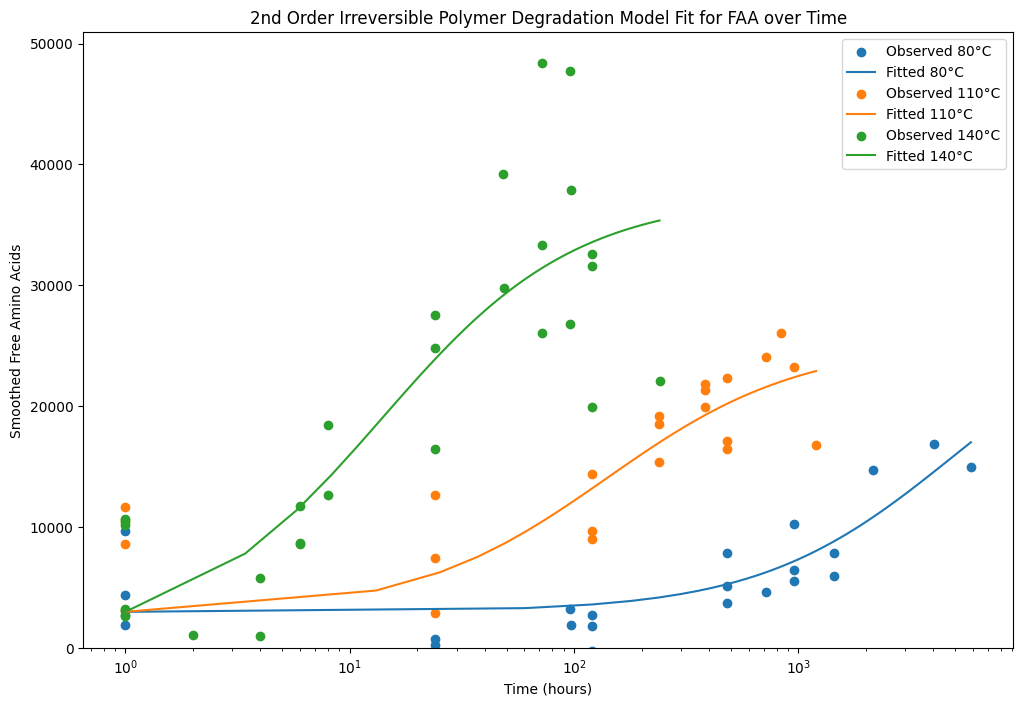

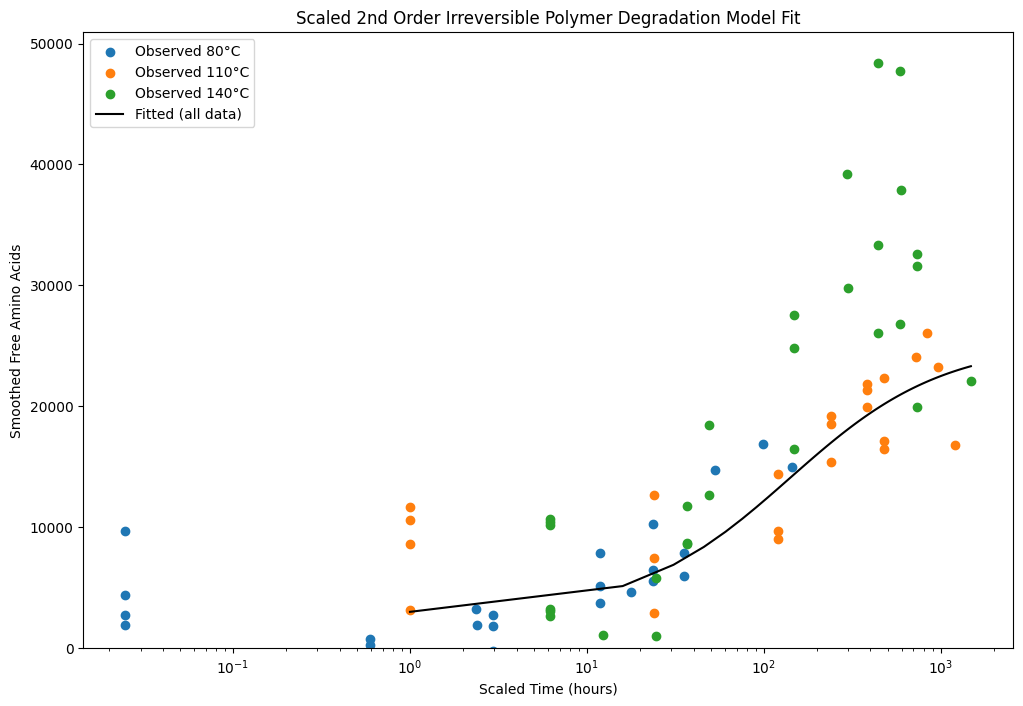

Fitted parameters with water estimation: k = 2.876483e-04, A = 31649.96, W = 0.0010


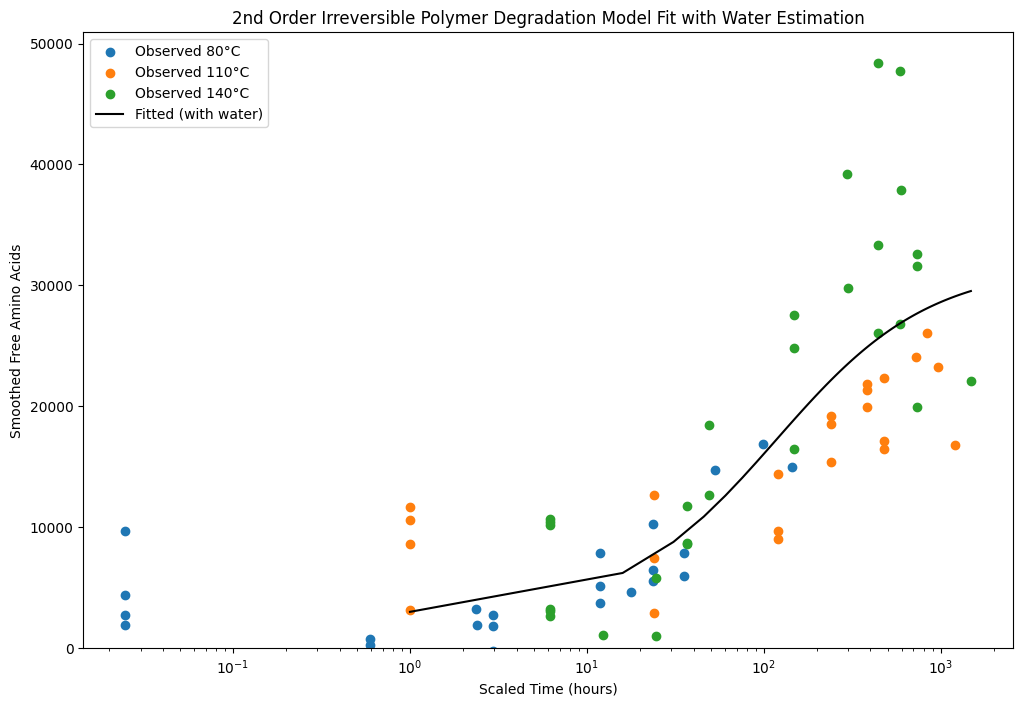

Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
from datetime import datetime

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
INITIAL_CONC = 3000  # Force initial concentration to 3000

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y, T):
    k, A = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    y_pred = polymer_degradation_model(t, k_T, A)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]

        bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5)]  # (k, A)
        result = differential_evolution(objective, bounds, args=(t, y, T), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Calculate rate constants and plot results
plt.figure(figsize=(12, 8))
rate_constants = {}

for temp in [80, 110, 140]:
    k, A = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T

    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    t_range = np.linspace(1, temp_data['time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, k_T, A)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

    print(f"Fitted parameters for {temp}°C: k = {k_T:.6e}, A = {A:.2f}")

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Plot with scaled rates
plt.figure(figsize=(12, 8))
scaled_data = []

for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    scale_factor = rate_constants[temp] / rate_constants[110]  # Scale to 110°C
    scaled_time = temp_data['time'] * scale_factor
    plt.scatter(scaled_time, temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    scaled_data.append(pd.DataFrame({
        'scaled_time': scaled_time,
        'smoothed_FAA': temp_data['smoothed_FAA'],
        'temp': temp
    }))

# Fit curve to all scaled data
all_scaled_data = pd.concat(scaled_data)
k_110, A_110 = fit_results[110]
t_range = np.linspace(1, all_scaled_data['scaled_time'].max(), 100)
fitted_FAA = polymer_degradation_model(t_range, k_110, A_110)
plt.plot(t_range, fitted_FAA, label='Fitted (all data)', color='black')

plt.xlabel("Scaled Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("Scaled 2nd Order Irreversible Polymer Degradation Model Fit")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Refit the model with water estimation
def polymer_degradation_model_with_water(t, k, A, W):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * (A - INITIAL_CONC) * W * (t - 1)) ** (-1))

def objective_with_water(params, t, y):
    k, A, W = params
    y_pred = polymer_degradation_model_with_water(t, k, A, W)
    return np.sum((y - y_pred) ** 2)

# Fit the model with water estimation
bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5), (0, 1)]  # (k, A, W)
result_with_water = differential_evolution(objective_with_water, bounds, args=(all_scaled_data['scaled_time'], all_scaled_data['smoothed_FAA']), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)

k_fitted, A_fitted, W_fitted = result_with_water.x

print(f"Fitted parameters with water estimation: k = {k_fitted:.6e}, A = {A_fitted:.2f}, W = {W_fitted:.4f}")

# Plot results with water estimation
plt.figure(figsize=(12, 8))
for temp in [80, 110, 140]:
    temp_data = all_scaled_data[all_scaled_data['temp'] == temp]
    plt.scatter(temp_data['scaled_time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

t_range = np.linspace(1, all_scaled_data['scaled_time'].max(), 100)
fitted_FAA = polymer_degradation_model_with_water(t_range, k_fitted, A_fitted, W_fitted)
plt.plot(t_range, fitted_FAA, label='Fitted (with water)', color='black')

plt.xlabel("Scaled Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit with Water Estimation")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare data for CSV
current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_data = {
    'Date': [current_date],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Initial Concentration': [INITIAL_CONC],
    'k (80°C)': [fit_results[80][0]],
    'k (110°C)': [fit_results[110][0]],
    'k (140°C)': [fit_results[140][0]],
    'A (80°C)': [fit_results[80][1]],
    'A (110°C)': [fit_results[110][1]],
    'A (140°C)': [fit_results[140][1]],
    'Rate Constant (80°C)': [rate_constants[80]],
    'Rate Constant (110°C)': [rate_constants[110]],
    'Rate Constant (140°C)': [rate_constants[140]],
    'Rate difference (140°C / 80°C)': [rate_constants[140] / rate_constants[80]],
    'k (with water)': [k_fitted],
    'A (with water)': [A_fitted],
    'W (water estimation)': [W_fitted]
}

# Create DataFrame and save to CSV
results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

# If the file doesn't exist, create it with headers. If it exists, append without headers.
if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

Fitted parameters for 80°C: k = 7.866315e-09, A = 28781.67
Fitted parameters for 110°C: k = 3.192092e-07, A = 25250.73
Fitted parameters for 140°C: k = 1.961073e-06, A = 37370.73
Rate difference (140°C / 80°C): 249.30


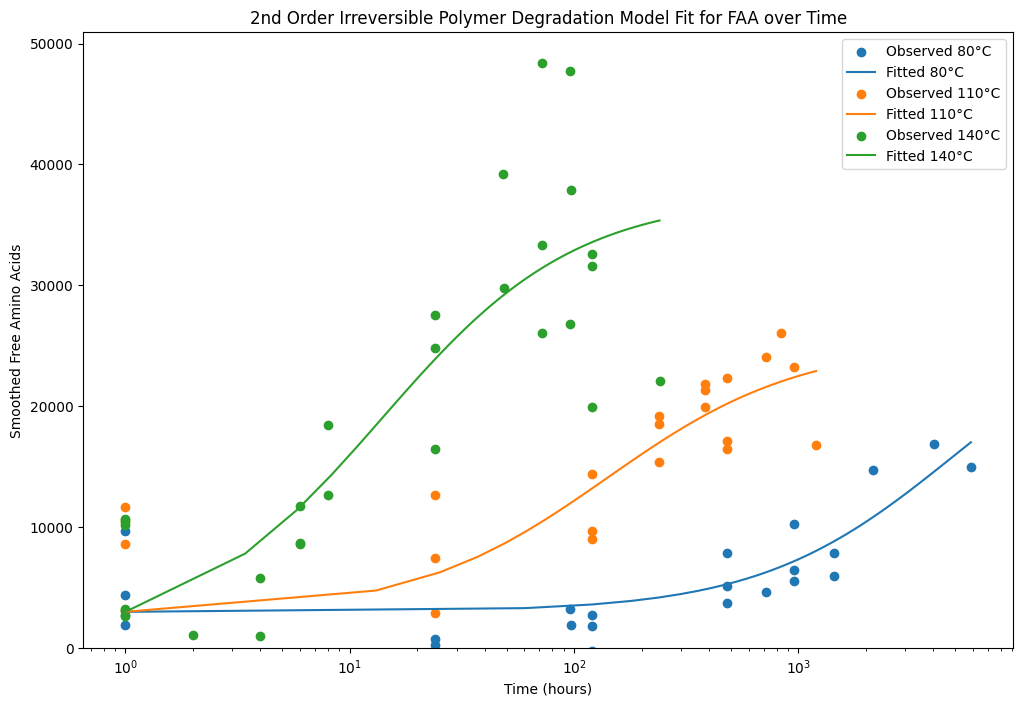

Results saved to /content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
from datetime import datetime
import os  # Import the os module

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
INITIAL_CONC = 3000  # Force initial concentration to 3000

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y, T):
    k, A = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    y_pred = polymer_degradation_model(t, k_T, A)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]

        bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5)]  # (k, A)
        result = differential_evolution(objective, bounds, args=(t, y, T), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Calculate rate constants and plot results
plt.figure(figsize=(12, 8))
rate_constants = {}

for temp in [80, 110, 140]:
    k, A = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T

    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    t_range = np.linspace(1, temp_data['time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, k_T, A)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

    print(f"Fitted parameters for {temp}°C: k = {k_T:.6e}, A = {A:.2f}")

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare data for CSV
current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_data = {
    'Date': [current_date],
    'Activation Energy (kJ/mol)': [Ea / 1000],
    'Initial Concentration': [INITIAL_CONC],
    'k (80°C)': [fit_results[80][0]],
    'k (110°C)': [fit_results[110][0]],
    'k (140°C)': [fit_results[140][0]],
    'A (80°C)': [fit_results[80][1]],
    'A (110°C)': [fit_results[110][1]],
    'A (140°C)': [fit_results[140][1]],
    'Rate Constant (80°C)': [rate_constants[80]],
    'Rate Constant (110°C)': [rate_constants[110]],
    'Rate Constant (140°C)': [rate_constants[140]],
    'Rate difference (140°C / 80°C)': [rate_constants[140] / rate_constants[80]]
}

# Create DataFrame and save to CSV
results_df = pd.DataFrame(results_data)
output_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/polymer_degradation_results.csv'

# If the file doesn't exist, create it with headers. If it exists, append without headers.
if not os.path.isfile(output_path):
    results_df.to_csv(output_path, index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"Results saved to {output_path}")

Fitted parameters for 80°C: k = 7.866315e-09, A = 28781.67
Fitted parameters for 110°C: k = 3.192092e-07, A = 25250.73
Fitted parameters for 140°C: k = 1.961073e-06, A = 37370.73
Rate difference (140°C / 80°C): 249.30


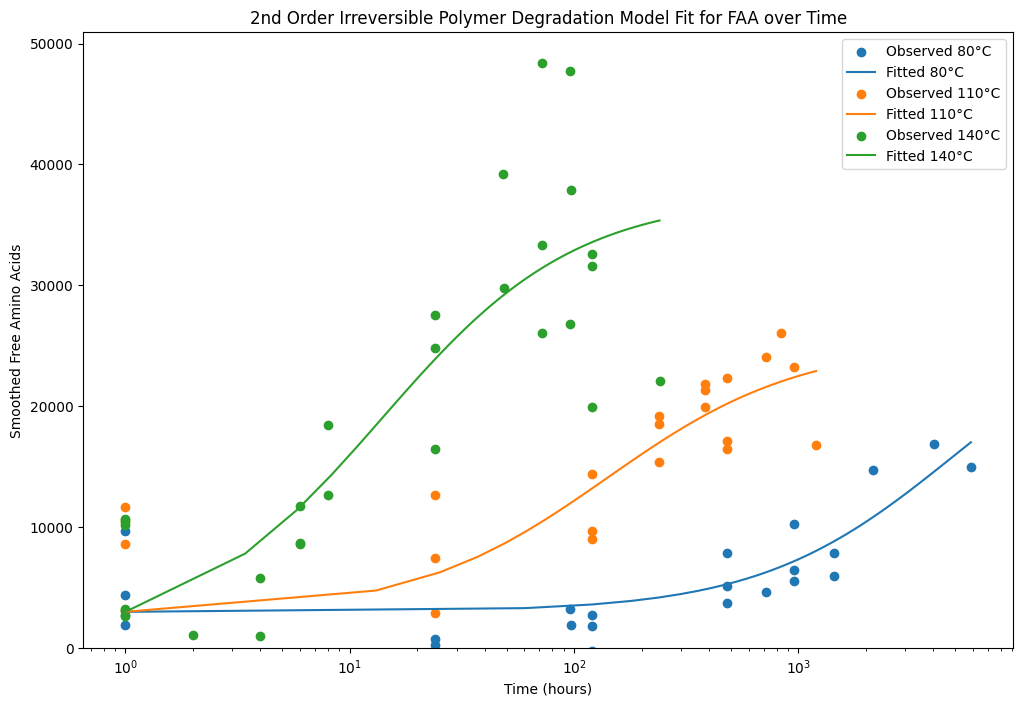

APIError: {'code': 429, 'message': "Quota exceeded for quota metric 'Read requests' and limit 'Read requests per minute' of service 'sheets.googleapis.com' for consumer 'project_number:522309567947'.", 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'RATE_LIMIT_EXCEEDED', 'domain': 'googleapis.com', 'metadata': {'quota_limit': 'ReadRequestsPerMinutePerProject', 'quota_limit_value': '900', 'quota_location': 'global', 'quota_metric': 'sheets.googleapis.com/read_requests', 'service': 'sheets.googleapis.com', 'consumer': 'projects/522309567947'}}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Request a higher quota limit.', 'url': 'https://cloud.google.com/docs/quota#requesting_higher_quota'}]}]}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
import gspread
from google.auth import default
from google.colab import auth

# Authentication code remains the same

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Apply Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
INITIAL_CONC = 3000  # Force initial concentration to 3000

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A):
    return INITIAL_CONC + (A - INITIAL_CONC) * (1 - (1 + k * (A - INITIAL_CONC) * (t - 1)) ** (-1))

# Objective function for optimization
def objective(params, t, y, T):
    k, A = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    y_pred = polymer_degradation_model(t, k_T, A)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]

        bounds = [(1e-10, 1e-3), (INITIAL_CONC, 1e5)]  # (k, A)
        result = differential_evolution(objective, bounds, args=(t, y, T), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Calculate rate constants and plot results
plt.figure(figsize=(12, 8))
rate_constants = {}

for temp in [80, 110, 140]:
    k, A = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T

    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    t_range = np.linspace(1, temp_data['time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, k_T, A)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

    print(f"Fitted parameters for {temp}°C: k = {k_T:.6e}, A = {A:.2f}")

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare data for Google Sheets
activation_energy = [['Activation Energy (kJ/mol)', Ea / 1000]]

rate_constants_sheet = [
    ['Temperature (°C)', 'Rate Constant (L mol^-1 hr^-1)'],
    [80, rate_constants[80]],
    [110, rate_constants[110]],
    [140, rate_constants[140]]
]

model_parameters = [
    ['Parameter', 'Value'],
    ['Initial Concentration', INITIAL_CONC]
] + [
    [f'k ({temp}°C)', fit_results[temp][0]] for temp in [80, 110, 140]
] + [
    [f'A ({temp}°C)', fit_results[temp][1]] for temp in [80, 110, 140]
]

# Write data to Google Sheets
sheet_id = '1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E'  # Replace with your Google Sheet ID
write_data(sheet_id, '1475619581', activation_energy)
write_data(sheet_id, '2026572251', rate_constants_sheet)
write_data(sheet_id, '853563460', model_parameters)

Fitted parameters for 80°C: k = 4.747721e-09, A = 30838.64, B = 2777.20
Fitted parameters for 110°C: k = 1.703587e-07, A = 17554.68, B = 9438.02
Fitted parameters for 140°C: k = 2.178042e-06, A = 34829.45, B = 1782.08
Rate difference (140°C / 80°C): 458.76


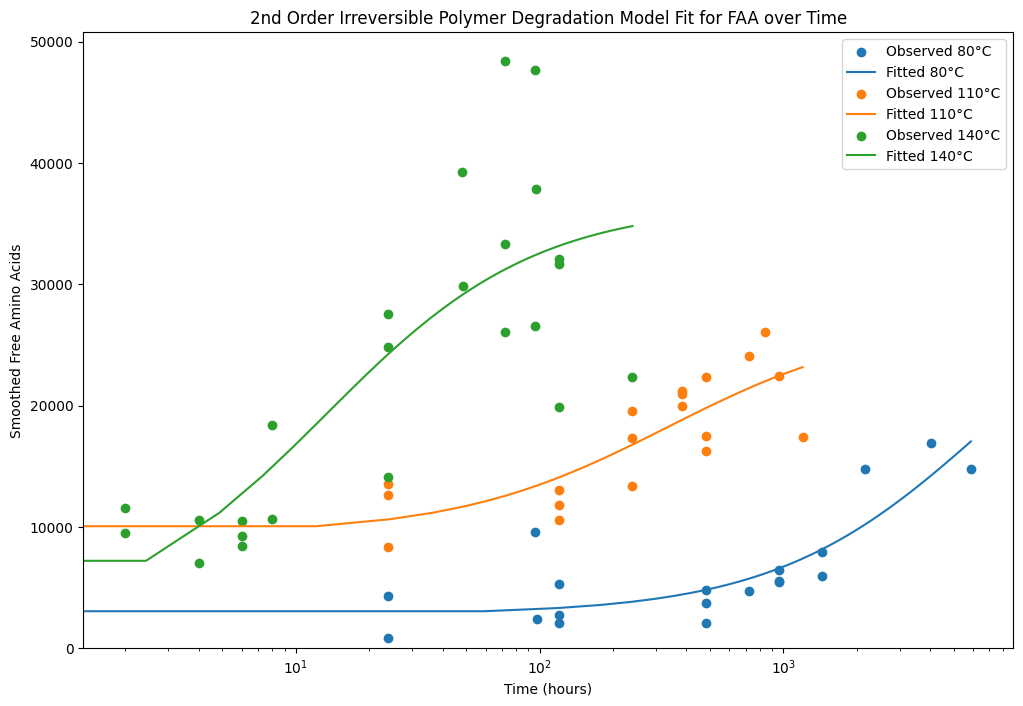

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.signal import savgol_filter
import gspread
from google.auth import default
from google.colab import auth

# Authentication code remains the same

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Remove time 1 value and apply Savitzky-Golay filter
data = data[data['time'] != 1]
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A, B):
    return A * (1 - (1 + k * A * t) ** (-1)) + B

# Objective function for optimization
def objective(params, t, y, T):
    k, A, B = params
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    y_pred = polymer_degradation_model(t, k_T, A, B)
    return np.sum((y - y_pred) ** 2)

# Fit the model for each temperature
def fit_model(data):
    results = {}
    for temp in [80, 110, 140]:
        temp_data = data[data['temp (°C)'] == temp]
        t = temp_data['time'].values
        y = temp_data['smoothed_FAA'].values
        T = temp_data['temp_K'].values[0]

        bounds = [(1e-10, 1e-3), (1, 1e5), (0, 1e4)]  # (k, A, B)
        result = differential_evolution(objective, bounds, args=(t, y, T), popsize=20, mutation=(0.5, 1.5), recombination=0.7, seed=42)
        results[temp] = result.x

    return results

# Fit the model
fit_results = fit_model(data)

# Calculate rate constants and plot results
plt.figure(figsize=(12, 8))
rate_constants = {}

for temp in [80, 110, 140]:
    k, A, B = fit_results[temp]
    T = temp + 273.15
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))
    rate_constants[temp] = k_T

    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    t_range = np.linspace(0, temp_data['time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, k_T, A, B)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

    print(f"Fitted parameters for {temp}°C: k = {k_T:.6e}, A = {A:.2f}, B = {B:.2f}")

print(f"Rate difference (140°C / 80°C): {rate_constants[140] / rate_constants[80]:.2f}")

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)
plt.show()

# Prepare and write data to Google Sheets
# (This part remains largely the same, but use the new rate_constants dictionary)

Fitted parameters: k (110°C) = 3.588709e-04, A = 17398.50
Rate constants: k (80°C) = 2.629930e-05, k (110°C) = 3.588709e-04, k (140°C) = 3.350441e-03
Rate difference (140°C / 80°C): 127.40


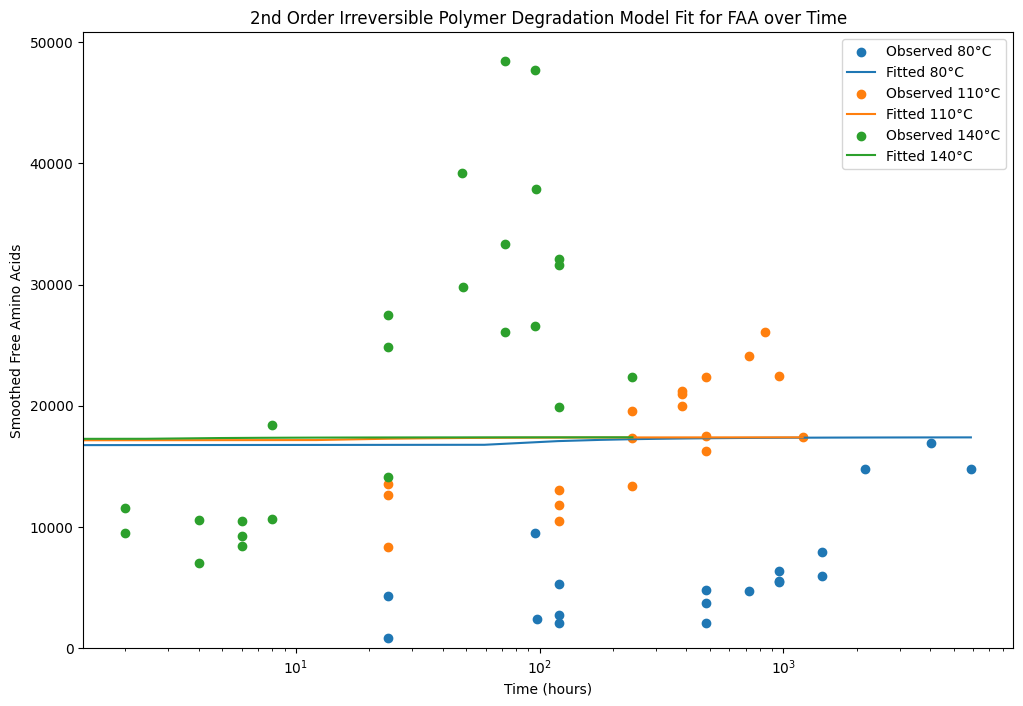

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import gspread
from google.auth import default
from google.colab import auth

# Authenticate and initialize the gspread client
auth.authenticate_user()
creds, _ = default()
client = gspread.authorize(creds)

def write_data(sheet_id, gid, rows):
    """Write data to Google Sheets using OAuth 2.0 Client ID."""
    sheet = client.open_by_key(sheet_id).get_worksheet_by_id(int(gid))
    for row in rows:
        sheet.append_row(row)

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Remove time 1 value
data = data[data['time'] != 1]

# Smooth the FAA data using Savitzky-Golay filter
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
N = 100000  # Total number of amino acids
L = 125  # Initial polymer length

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A, T):
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))  # Adjust rate constant for temperature
    return A * (1 - (1 + k_T * A * t) ** (-1))

# Fit the model
def fit_model(data):
    # Initial guesses for the parameters
    k_initial = 1e-6  # Initial guess for rate constant at 110°C
    A_initial = N / L  # Initial guess for total number of polymer chains

    # Fit the model
    popt, _ = curve_fit(
        lambda t, k, A: polymer_degradation_model(t, k, A, data['temp_K'].iloc[0]),
        data['time'],
        data['smoothed_FAA'],
        p0=[k_initial, A_initial],
        bounds=([0, 0], [np.inf, np.inf]),
        maxfev=10000
    )

    return popt

# Fit the model
popt = fit_model(data)
k_fitted, A_fitted = popt

# Calculate rate constants at different temperatures
def calculate_rate_constant(T):
    return k_fitted * np.exp(-Ea / R * (1 / T - 1 / 383.15))

k_80C = calculate_rate_constant(353.15)
k_110C = calculate_rate_constant(383.15)
k_140C = calculate_rate_constant(413.15)

print(f"Fitted parameters: k (110°C) = {k_fitted:.6e}, A = {A_fitted:.2f}")
print(f"Rate constants: k (80°C) = {k_80C:.6e}, k (110°C) = {k_110C:.6e}, k (140°C) = {k_140C:.6e}")
print(f"Rate difference (140°C / 80°C): {k_140C / k_80C:.2f}")

# Plot results
plt.figure(figsize=(12, 8))
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    # Generate fitted curve
    t_range = np.linspace(0, temp_data['time'].max(), 100)
    fitted_FAA = polymer_degradation_model(t_range, k_fitted, A_fitted, temp + 273.15)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Free Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for FAA over Time")
plt.legend()
plt.xscale('log')
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.show()

# Prepare data for Google Sheets
activation_energy = [['Activation Energy (kJ/mol)', Ea / 1000]]

rate_constants = [
    ['Temperature (°C)', 'Rate Constant (L mol^-1 hr^-1)'],
    [80, k_80C],
    [110, k_110C],
    [140, k_140C]
]

model_parameters = [
    ['Parameter', 'Value'],
    ['k (110°C)', k_fitted],
    ['A', A_fitted]
]

# Write data to Google Sheets
sheet_id = '1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E'  # Replace with your Google Sheet ID
write_data(sheet_id, '1475619581', activation_energy)
write_data(sheet_id, '2026572251', rate_constants)
write_data(sheet_id, '853563460', model_parameters)

Fitted parameters: k (110°C) = 1.019621e+05, A = 16523.23
Rate constants: k (80°C) = 7.472132e+03, k (110°C) = 1.019621e+05, k (140°C) = 9.519241e+05
Rate difference (140°C / 80°C): 127.40


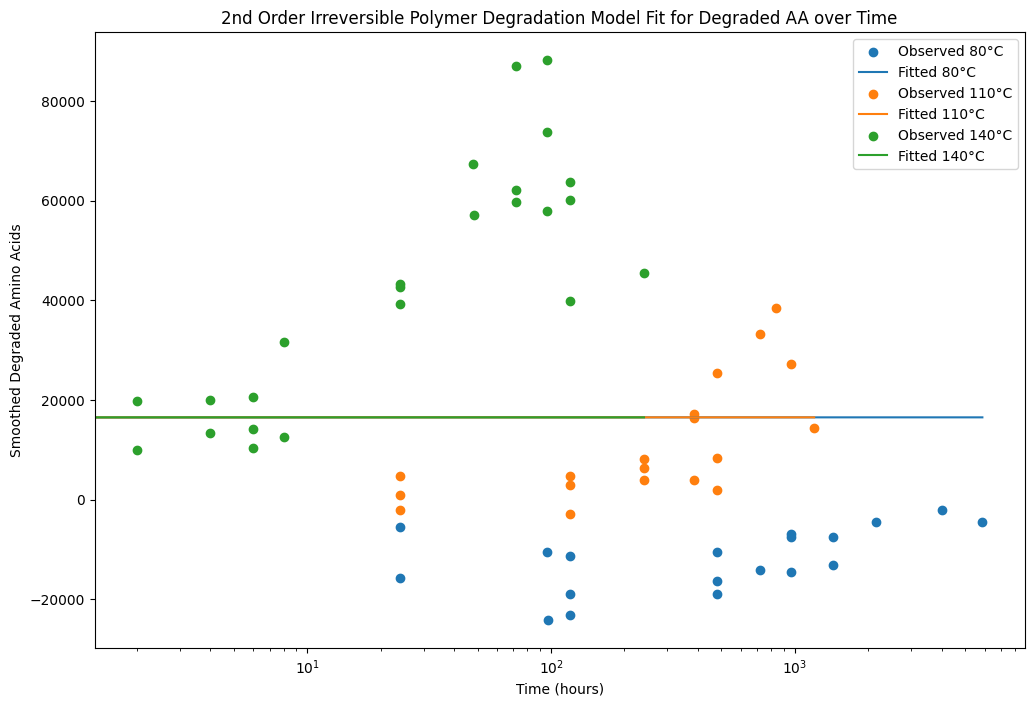

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import gspread
from google.auth import default
from google.colab import auth

# Authenticate and initialize the gspread client
auth.authenticate_user()
creds, _ = default()
client = gspread.authorize(creds)

def write_data(sheet_id, gid, rows):
    """Write data to Google Sheets using OAuth 2.0 Client ID."""
    sheet = client.open_by_key(sheet_id).get_worksheet_by_id(int(gid))
    for row in rows:
        sheet.append_row(row)

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Remove time 1 value
data = data[data['time'] != 1]

# Calculate total degraded amino acids
data['initial_THAA'] = data.groupby('temp (°C)')['THAA_total'].transform('first')
data['degraded_AA'] = data['initial_THAA'] - data['THAA_total'] + data['FAA_total']

# Smooth the degraded AA data using Savitzky-Golay filter
data['smoothed_degraded_AA'] = savgol_filter(data['degraded_AA'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol
N = 100000  # Total number of amino acids
L = 125  # Initial polymer length

# Define the 2nd order irreversible polymer degradation model
def polymer_degradation_model(t, k, A, T):
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))  # Adjust rate constant for temperature
    return A * (1 - (1 + k_T * A * t) ** (-1))

# Fit the model
def fit_model(data):
    # Initial guesses for the parameters
    k_initial = 1e-6  # Initial guess for rate constant at 110°C
    A_initial = N / L  # Initial guess for total number of polymer chains

    # Fit the model
    popt, _ = curve_fit(
        lambda t, k, A: polymer_degradation_model(t, k, A, data['temp_K'].iloc[0]),
        data['time'],
        data['smoothed_degraded_AA'],
        p0=[k_initial, A_initial],
        bounds=([0, 0], [np.inf, np.inf]),
        maxfev=10000
    )

    return popt

# Fit the model
popt = fit_model(data)
k_fitted, A_fitted = popt

# Calculate rate constants at different temperatures
def calculate_rate_constant(T):
    return k_fitted * np.exp(-Ea / R * (1 / T - 1 / 383.15))

k_80C = calculate_rate_constant(353.15)
k_110C = calculate_rate_constant(383.15)
k_140C = calculate_rate_constant(413.15)

print(f"Fitted parameters: k (110°C) = {k_fitted:.6e}, A = {A_fitted:.2f}")
print(f"Rate constants: k (80°C) = {k_80C:.6e}, k (110°C) = {k_110C:.6e}, k (140°C) = {k_140C:.6e}")
print(f"Rate difference (140°C / 80°C): {k_140C / k_80C:.2f}")

# Plot results
plt.figure(figsize=(12, 8))
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_degraded_AA'], label=f'Observed {temp}°C')

    # Generate fitted curve
    t_range = np.linspace(0, temp_data['time'].max(), 100)
    fitted_degraded_AA = polymer_degradation_model(t_range, k_fitted, A_fitted, temp + 273.15)
    plt.plot(t_range, fitted_degraded_AA, label=f'Fitted {temp}°C')

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed Degraded Amino Acids")
plt.title("2nd Order Irreversible Polymer Degradation Model Fit for Degraded AA over Time")
plt.legend()
plt.xscale('log')
plt.show()

# Prepare data for Google Sheets
activation_energy = [['Activation Energy (kJ/mol)', Ea / 1000]]

rate_constants = [
    ['Temperature (°C)', 'Rate Constant (L mol^-1 hr^-1)'],
    [80, k_80C],
    [110, k_110C],
    [140, k_140C]
]

model_parameters = [
    ['Parameter', 'Value'],
    ['k (110°C)', k_fitted],
    ['A', A_fitted]
]

# Write data to Google Sheets
sheet_id = '1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E'  # Replace with your Google Sheet ID
write_data(sheet_id, '1475619581', activation_energy)
write_data(sheet_id, '2026572251', rate_constants)
write_data(sheet_id, '853563460', model_parameters)

Fitted parameters: k (110°C) = 0.099131, A = 76123.57, H2O_initial = 76980.37
Rate constants: k (80°C) = 0.007265, k (110°C) = 0.099131, k (140°C) = 0.925489
Rate difference (140°C / 80°C): 127.40


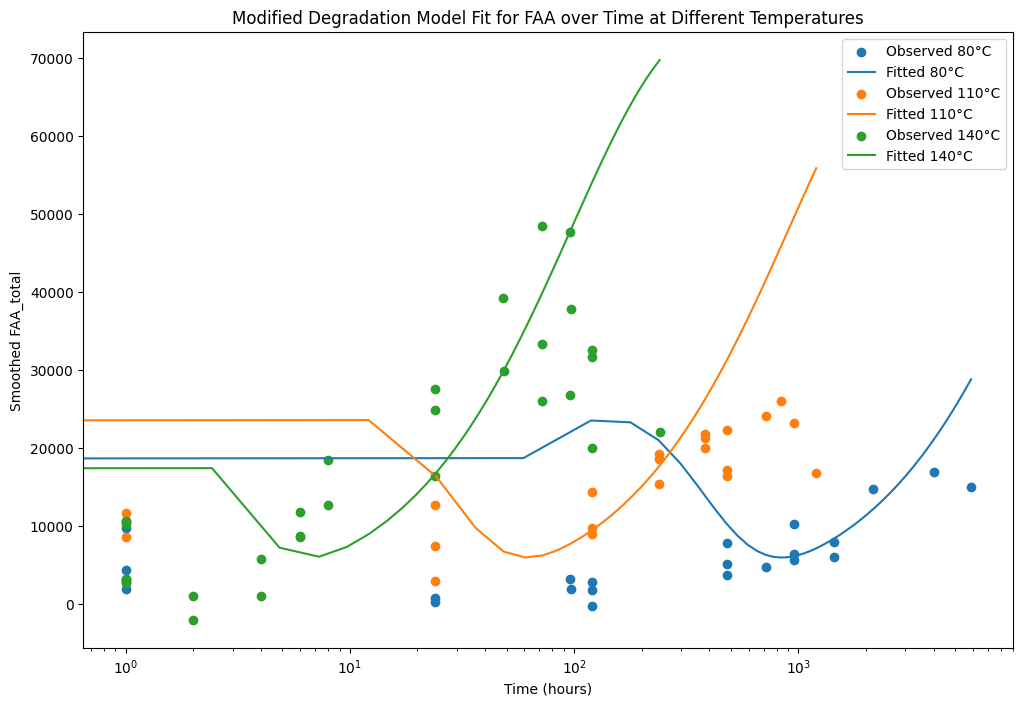

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import gspread
from google.auth import default
from google.colab import auth

# Authenticate and initialize the gspread client
auth.authenticate_user()
creds, _ = default()
client = gspread.authorize(creds)

def write_data(sheet_id, gid, rows):
    """Write data to Google Sheets using OAuth 2.0 Client ID."""
    sheet = client.open_by_key(sheet_id).get_worksheet_by_id(int(gid))  # gid needs to be an integer
    for row in rows:
        sheet.append_row(row)

# Load and preprocess data
data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
data = pd.read_csv(data_path)
data['temp_K'] = data['temp (°C)'] + 273.15

# Smooth the THAA and FAA data using Savitzky-Golay filter
data['smoothed_THAA'] = savgol_filter(data['THAA_total'], window_length=7, polyorder=3)
data['smoothed_FAA'] = savgol_filter(data['FAA_total'], window_length=7, polyorder=3)

# Constants
R = 8.314  # Gas constant in J/(mol·K)
Ea = 98000  # Activation energy in J/mol

# Define the modified degradation model accounting for water concentration
def modified_degradation_model(t, k, A, H2O_initial, T):
    k_T = k * np.exp(-Ea / R * (1 / T - 1 / 383.15))  # Adjust rate constant for temperature
    H2O_t = H2O_initial - A * (1 - np.exp(-k_T * t))
    H2O_t = np.maximum(H2O_t, 0)  # Ensure water concentration doesn't go negative
    return A * (1 - np.exp(-k_T * t * H2O_t / H2O_initial))

# Fit the model
def fit_model(data):
    # Initial guesses for the parameters
    k_initial = 0.032456  # Initial guess for rate constant at 110°C
    A_initial = 58869.43  # Initial guess for total amino acids
    H2O_initial_guess = 64556.75  # Initial guess for water molecules

    # Fit the model
    popt, _ = curve_fit(
        lambda t, k, A, H2O_initial: modified_degradation_model(t, k, A, H2O_initial, data['temp_K'].iloc[0]),
        data['time'],
        data['smoothed_FAA'],
        p0=[k_initial, A_initial, H2O_initial_guess]
    )

    return popt

# Fit the model
popt = fit_model(data)
k_fitted, A_fitted, H2O_initial_fitted = popt

# Calculate rate constants at different temperatures
def calculate_rate_constant(T):
    return k_fitted * np.exp(-Ea / R * (1 / T - 1 / 383.15))

k_80C = calculate_rate_constant(353.15)
k_110C = calculate_rate_constant(383.15)
k_140C = calculate_rate_constant(413.15)

print(f"Fitted parameters: k (110°C) = {k_fitted:.6f}, A = {A_fitted:.2f}, H2O_initial = {H2O_initial_fitted:.2f}")
print(f"Rate constants: k (80°C) = {k_80C:.6f}, k (110°C) = {k_110C:.6f}, k (140°C) = {k_140C:.6f}")
print(f"Rate difference (140°C / 80°C): {k_140C / k_80C:.2f}")

# Plot results
plt.figure(figsize=(12, 8))
for temp in [80, 110, 140]:
    temp_data = data[data['temp (°C)'] == temp]
    plt.scatter(temp_data['time'], temp_data['smoothed_FAA'], label=f'Observed {temp}°C')

    # Generate fitted curve
    t_range = np.linspace(0, temp_data['time'].max(), 100)
    fitted_FAA = modified_degradation_model(t_range, k_fitted, A_fitted, H2O_initial_fitted, temp + 273.15)
    plt.plot(t_range, fitted_FAA, label=f'Fitted {temp}°C')

plt.xlabel("Time (hours)")
plt.ylabel("Smoothed FAA_total")
plt.title("Modified Degradation Model Fit for FAA over Time at Different Temperatures")
plt.legend()
plt.xscale('log')
plt.show()

# Prepare data for Google Sheets
activation_energy = [['Activation Energy (kJ/mol)', Ea / 1000]]

rate_constants = [
    ['Temperature (°C)', 'Rate Constant (hr^-1)'],
    [80, k_80C],
    [110, k_110C],
    [140, k_140C]
]

model_parameters = [
    ['Parameter', 'Value'],
    ['k (110°C)', k_fitted],
    ['A', A_fitted],
    ['H2O_initial', H2O_initial_fitted]
]

# Write data to Google Sheets
sheet_id = '1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E'  # Replace with your Google Sheet ID
write_data(sheet_id, '1475619581', activation_energy)
write_data(sheet_id, '2026572251', rate_constants)
write_data(sheet_id, '853563460', model_parameters)


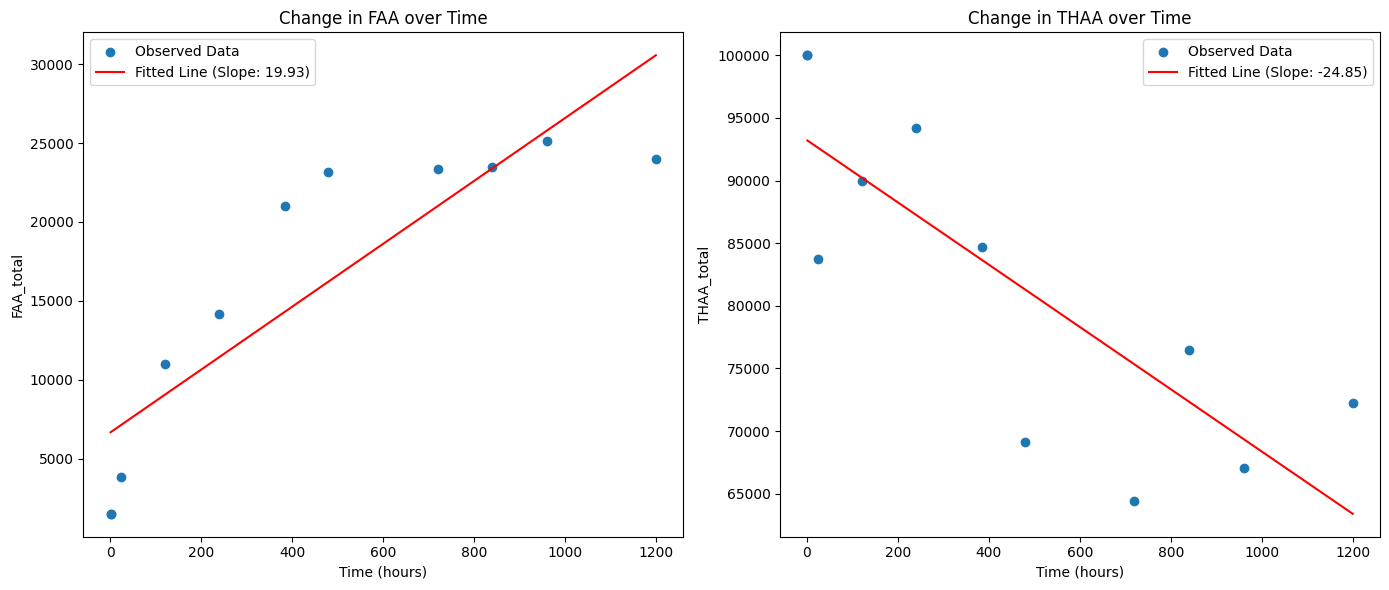

(19.929334901831353, -24.852352827090122)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


# Data preparation
data = {
    "temp (°C)": [110] * 11,
    "time (hours)": [1, 1, 24, 120, 240, 384, 480, 720, 840, 960, 1200],
    "pH": [7] * 11,
    "BAA_total": [98498.36095, 98498.36095, 79897.57287, 78966.01583, 79999.11701, 63710.11357, 45940.99403, 41118.75145, 52937.60555, 41900.19978, 48268.78291],
    "FAA_total": [1501.639055, 1501.639055, 3852.054613, 11002.08607, 14158.78412, 21022.94677, 23192.90074, 23327.55709, 23503.05184, 25118.92805, 24008.56503],
    "THAA_total": [100000, 100000, 83749.62749, 89968.1019, 94157.90113, 84733.06034, 69133.89477, 64446.30854, 76440.65739, 67019.12782, 72277.34793]
}

df = pd.DataFrame(data)

# Linear regression for FAA
slope_faa, intercept_faa, r_value_faa, p_value_faa, std_err_faa = linregress(df["time (hours)"], df["FAA_total"])

# Linear regression for THAA
slope_thaa, intercept_thaa, r_value_thaa, p_value_thaa, std_err_thaa = linregress(df["time (hours)"], df["THAA_total"])

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot for FAA
plt.subplot(1, 2, 1)
plt.scatter(df["time (hours)"], df["FAA_total"], label="Observed Data")
plt.plot(df["time (hours)"], intercept_faa + slope_faa * df["time (hours)"], 'r', label=f"Fitted Line (Slope: {slope_faa:.2f})")
plt.xlabel("Time (hours)")
plt.ylabel("FAA_total")
plt.title("Change in FAA over Time")
plt.legend()

# Plot for THAA
plt.subplot(1, 2, 2)
plt.scatter(df["time (hours)"], df["THAA_total"], label="Observed Data")
plt.plot(df["time (hours)"], intercept_thaa + slope_thaa * df["time (hours)"], 'r', label=f"Fitted Line (Slope: {slope_thaa:.2f})")
plt.xlabel("Time (hours)")
plt.ylabel("THAA_total")
plt.title("Change in THAA over Time")
plt.legend()

plt.tight_layout()
plt.show()

# # Display the dataframe
# tools.display_dataframe_to_user(name="Amino Acids Data Analysis", dataframe=df)

# Display the results
slope_faa, slope_thaa
